# About

This is an experimental notebook to model a Churn Classifier. The functions are in progress, so they are a bit messy at the start. Gradually as I modularize the code more, they become a bit more organized.

I underwent the following steps:
- `Preparation`: Transform seed data format to be suitable for feature engineering.
- Feature Transformation
    - `Test Feature Transformation Pipeline 1`
        - `Feature Engineering`: Generate features using the following information:
            - Window Features
            - RFM Features
            - Activity Trend Features
                - Slope
                - Statistics
            - I gathered 106 features in total.
        - `Data Split`: Split data into train, test, val sets with dependent and independent variables.
        - `Feature Processing`: Transform features (impute, scale) then select features with good Mutual Information contribution.
        - `Write Transformation Models`: Temporarily dump the transformed dataframes and transformers so I can continue experimenting without having to rerun the notebook.
    - `Complete Feature Transformation Pipeline 1`: Wrap the entire Pipeline 1 into respective functions. Then write the dataframes and transformers again.
- `Model Test`: Try some Tree classifiers on one target. The results were horrendous (around 0.5 PR-AUC), so I wondered if raw features were better.
- `Test Feature Transformation Pipeline 2`: Instead of the transformed features, use the raw features to see if AUC is any better. Results: Similar results as transformed version.
-  `Log Results`:
    - Data Pipeline: Wrap the data pipelines above into callable functions that generates and writes down:
        - Raw features dataframes
        - Transformed features dataframes
        - Transformers (imputer, scaler, selected features)
    - Train & Log Models: Use mlflow to log models and metrics with the best performance for each target using different types of data.
        - Conclusion: AUC gets worse when the prediction window is larger. The model can not predict for 90 days at all. The transformed features are mostly better than the raw features and results in PR-AUC that is slightly better than random guessing (0.55)
- `Call Models`: Get the current production model for respective target for inference.

# Preparation

## Libraries

In [94]:
import pandas as pd

In [95]:
import numpy as np

In [96]:
from dotenv import load_dotenv
import os

In [97]:
import maika_eda_pandas as mk

In [98]:
from scipy import stats

In [99]:
from src.core.transforms import (
    transform_transactions_df,
    transform_customers_df,
    get_customers_screenshot_summary_from_transactions_df,
    add_churn_status,
)

In [100]:
import plotly.express as px
import plotly.graph_objects as go

In [101]:
# Features Processing

from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif

In [102]:
import joblib
import json
from pathlib import Path

In [103]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [104]:
from imblearn.over_sampling import SMOTE

In [105]:
import matplotlib.pyplot as plt

In [106]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    average_precision_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

In [107]:
import mlflow
from mlflow.models import infer_signature

In [108]:
import tempfile

In [109]:
from sklearn.model_selection import GridSearchCV

In [110]:
from sklearn.metrics import make_scorer

In [193]:
from itertools import product
import traceback

In [ ]:
import shutil

## Environment

In [111]:
load_dotenv()

True

In [112]:
PROJECT_ROOT = Path.cwd().parent

In [113]:
MAX_DATA_DATE = pd.Timestamp('2025-12-31')
MAX_DATA_DATE_STR = MAX_DATA_DATE.strftime("%d_%m_%Y")
TRAIN_SNAPSHOT_DATE = MAX_DATA_DATE - pd.Timedelta(90, 'day')

In [114]:
BASE_GOLD_DIR = PROJECT_ROOT / "data" / "gold" / MAX_DATA_DATE_STR

In [214]:
CLASSIFIER_DATA_PATH = BASE_GOLD_DIR / "cut_120d" / "features" / "classifier"

In [115]:
# This is no longer used. Updated to mlflow instead.
#ARTIFACT_DIR = PROJECT_ROOT / MAX_DATA_DATE_STR / "/src/models/preprocessing"

In [117]:
SEED_CUSTOMERS=os.getenv("SEED_CUSTOMERS")
SEED_TRANSACTIONS=os.getenv("SEED_TRANSACTIONS")

In [118]:
targets = [
    "is_churn_30_days",
    "is_churn_60_days",
    "is_churn_90_days",
]

In [194]:
EXPERIMENT_NAME = "churn_prediction"

In [120]:
ARTIFACT_DIR = Path(tempfile.mkdtemp())

In [121]:
PREPROCESSING_REF_DIR = (
    BASE_GOLD_DIR / "reference" / "preprocessing"
)
PREPROCESSING_REF_DIR.mkdir(parents=True, exist_ok=True)

In [187]:
MLRUNS_DIR = PROJECT_ROOT / "mlruns"

mlflow.set_tracking_uri(f"file://{MLRUNS_DIR}")
print("Tracking URI:", mlflow.get_tracking_uri())

from mlflow.tracking import MlflowClient
client = MlflowClient()

Tracking URI: file:///home/hong-mai/Desktop/HONGMAI/Coding/ai-customer-growth-retention/mlruns


## Custom Wrappers

### Feature Engineering

In [125]:
def get_rfm_window_features(customers_df, transactions_df, observed_date):

    rfm_time_windows = ["all_time", "30d", "60d", "90d"]

    for rfm_time_window in rfm_time_windows:

        if rfm_time_window == "all_time":
            filtered_transactions_df = transactions_df
        else:
            # Limit data to the new cutoff
            days = int(rfm_time_window.strip("d"))
            filtered_transactions_df = transactions_df[
                (transactions_df['transaction_date'] <= observed_date - pd.Timedelta(days=days))
            ]

        # Get a Customers Screenshot Summary DataFrame. It has RFM features and other variables that RFM features depend on.
        summary_modeling_df = get_customers_screenshot_summary_from_transactions_df(
            transactions_df=filtered_transactions_df,
            observed_date=observed_date,
            column_names=["customer_id", "transaction_date", "amount"]
        )

        # Keep only customer_id and the RFM columns we care about
        summary_modeling_df = summary_modeling_df[[
            'customer_id',
            'days_until_observed',
            'period_transaction_count',
            'period_total_amount',
            'period_tenure_days'
        ]]

        # Rename columns in the summary DF, not the main DF
        summary_modeling_df = summary_modeling_df.rename(columns={
            'days_until_observed': f'rfm_recency_{rfm_time_window}',
            'period_transaction_count': f'rfm_frequency_{rfm_time_window}',
            'period_total_amount': f'rfm_monetary_{rfm_time_window}',
            'period_tenure_days': f'tenure_{rfm_time_window}'
        })
        
        # Merge with current data used for modelling.
        customers_df = pd.merge(
            customers_df,
            summary_modeling_df,
            on="customer_id",
            how="left"
        )

    return customers_df

In [126]:
def get_slope_features(customers_df, transactions_df, observed_date, feature_list):

    time_windows = ["all_time", "30d", "60d", "90d"]

    for time_window in time_windows:

        if time_window == "all_time":
            filtered_transactions_df = transactions_df
        else:
            # Limit data to the new cutoff
            days = int(time_window.strip("d"))
            filtered_transactions_df = transactions_df[
                (transactions_df['transaction_date'] <= observed_date - pd.Timedelta(days=days))
            ]

    customers_list = filtered_transactions_df['customer_id'].unique()

    slopes = {}

    for customer_id in customers_list:

        customer_transactions = filtered_transactions_df[filtered_transactions_df['customer_id'] == customer_id]

        x = np.arange(len(customer_transactions)) #time axis
        slopes[customer_id] = {} #initiate value list

        for feature_name in feature_list:
            y = customer_transactions[feature_name].values
            x_valid = x[~np.isnan(y)]
            y_valid = y[~np.isnan(y)]

            if len(y_valid) < 2:
                slopes[customer_id][feature_name] = np.nan
            else:
                slope = np.polyfit(x_valid, y_valid, 1)[0]
                slopes[customer_id][feature_name] = slope

    # Convert dict of dicts into dataframe
    slope_features_df = pd.DataFrame.from_dict(slopes, orient='index')

    # Rename columns to have slope_ prefix
    slope_features_df = slope_features_df.rename(columns={f: f'slope_{f}' for f in slope_features_df.columns})

    # Reset index to have customer_id as a column
    slope_features_df = slope_features_df.reset_index().rename(columns={'index': 'customer_id'})

    # Merge with current data used for modelling.
    customers_df = pd.merge(
        customers_df,
        slope_features_df,
        on="customer_id",
        how="left"
    )

    return customers_df

In [127]:
def get_transaction_statistics_features(customers_df, transactions_df, observed_date, feature_list):

    time_windows = ["all_time", "30d", "60d", "90d"]

    all_stats_df_list = []

    for time_window in time_windows:

        if time_window == "all_time":
            filtered_transactions_df = transactions_df
        else:
            # Limit data to the new cutoff
            days = int(time_window.strip("d"))
            filtered_transactions_df = transactions_df[
                (transactions_df['transaction_date'] <= observed_date - pd.Timedelta(days=days))
            ]

        customers_list = filtered_transactions_df['customer_id'].unique()
        stats_dict = {}

        for customer_id in customers_list:

            customer_transactions = filtered_transactions_df[
                filtered_transactions_df['customer_id'] == customer_id
            ]

            stats_dict[customer_id] = {}

            for feature_name in feature_list:

                y = customer_transactions[feature_name].dropna().values

                if len(y) < 2:
                    # Less than 2 observations -> return NaN for all stats
                    stats_dict[customer_id][f"min_{feature_name}"] = np.nan
                    stats_dict[customer_id][f"mean_{feature_name}"] = np.nan
                    stats_dict[customer_id][f"mode_{feature_name}"] = np.nan
                    stats_dict[customer_id][f"max_{feature_name}"] = np.nan
                    for q in [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]:
                        stats_dict[customer_id][f"q{q}_{feature_name}"] = np.nan
                    continue

                # Compute stats
                stats_dict[customer_id][f"min_{feature_name}"] = np.min(y)
                stats_dict[customer_id][f"mean_{feature_name}"] = np.mean(y)

                # Compute mode safely
                mode_result = stats.mode(y, nan_policy='omit')
                if hasattr(mode_result.mode, "__len__"):
                    # old SciPy: mode is array
                    mode_val = mode_result.mode[0] if len(mode_result.mode) > 0 else np.nan
                else:
                    # new SciPy: mode is scalar
                    mode_val = mode_result.mode if mode_result.count > 0 else np.nan

                stats_dict[customer_id][f"mode_{feature_name}"] = mode_val

                stats_dict[customer_id][f"max_{feature_name}"] = np.max(y)

                # Quantiles
                for q in [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]:
                    stats_dict[customer_id][f"q{q}_{feature_name}"] = np.percentile(y, q)

        # Convert to dataframe
        stats_df = pd.DataFrame.from_dict(stats_dict, orient='index').reset_index().rename(columns={'index': 'customer_id'})
        all_stats_df_list.append(stats_df)

    # Merge with customers_df (only keep last time_window stats)
    final_stats_df = all_stats_df_list[-1]  # or merge all windows if needed
    customers_df = pd.merge(customers_df, final_stats_df, on='customer_id', how='left')

    return customers_df

In [128]:
def build_training_base(
    seed_customers_path,
    seed_transactions_path,
    train_snapshot_date,
    churn_windows=[30, 60, 90],
):
    """
    Reads raw data, transforms it, limits it to modeling window,
    builds customer modeling table, and adds churn labels.
    """

    # --- Read data ---
    customers_df = pd.read_csv(seed_customers_path)
    transactions_df = pd.read_csv(seed_transactions_path)

    # --- Transform data ---
    transactions_df = transform_transactions_df(transactions_df)
    customers_df = transform_customers_df(customers_df)

    # --- Derive MAX_DATA_DATE internally ---
    max_data_date = transactions_df["transaction_date"].max()

    # --- Limit transactions to snapshot ---
    transactions_modeling_df = transactions_df.loc[
        transactions_df["transaction_date"] <= train_snapshot_date
    ]

    # --- Build customer modeling base ---
    customers_modeling_df = (
        pd.DataFrame({
            "customer_id": transactions_modeling_df["customer_id"].unique()
        })
        .merge(customers_df, on="customer_id", how="inner")
        .drop(columns=["signup_date", "true_lifetime_days", "termination_date"])
    )

    # --- Add churn labels ---
    for nday in churn_windows:
        var_name = f"is_churn_{nday}_days"
        observed_date = max_data_date - pd.Timedelta(days=nday)

        customers_modeling_df = add_churn_status(
            transformed_customers_df=customers_df,
            observed_date=observed_date,
            desired_df=None,
        )
        
        customers_modeling_df = customers_modeling_df.rename(columns={'is_churn': var_name})

    return transactions_modeling_df, customers_modeling_df

In [129]:
def add_transaction_time_features(transactions_df):
    """
    Add time-based and order-based transaction features.

    Parameters
    ----------
    transactions_df : pd.DataFrame
        Must contain: customer_id, transaction_date

    Returns
    -------
    pd.DataFrame
        Copy of transactions_df with added features
    """

    df = transactions_df.sort_values(
        ["customer_id", "transaction_date"]
    ).copy()

    df["customer_transaction_order"] = (
        df.groupby("customer_id").cumcount()
    )

    df["prev_transaction_date"] = (
        df.groupby("customer_id")["transaction_date"].shift(1)
    )

    df["next_transaction_date"] = (
        df.groupby("customer_id")["transaction_date"].shift(-1)
    )

    df["days_since_previous_transaction"] = (
        df["transaction_date"] - df["prev_transaction_date"]
    ).dt.days

    df["days_until_next_transaction"] = (
        df["next_transaction_date"] - df["transaction_date"]
    ).dt.days

    df["first_transaction_date"] = (
        df.groupby("customer_id")["transaction_date"]
        .transform("min")
    )

    df["days_since_first_transaction"] = (
        df["transaction_date"] - df["first_transaction_date"]
    ).dt.days

    return df

### Helpers

In [130]:
def check_nan_in_df_cols(df):
    # Get relative percentage of nulls by column
    null_features_proportion = (
        df.isna().sum() / len(df)
    ).sort_values(ascending=False)

    high_proportion = []
    medium_proportion = []
    low_proportion = []

    for feature, proportion in null_features_proportion.items():
        if proportion >= 0.20:
            high_proportion.append(feature)
        elif 0.05 <= proportion < 0.20:
            medium_proportion.append(feature)
        else:
            low_proportion.append(feature)

    # Build features DataFrame
    features_df = null_features_proportion.reset_index()
    features_df.columns = ["feature", "nan_proportion"]

    features_df["NaN group"] = features_df["feature"].apply(
        lambda f: (
            "High" if f in high_proportion
            else "Medium" if f in medium_proportion
            else "Low"
        )
    )

    # Print counts (same behavior as before)
    print("Total features:", len(df.columns))
    print("Information on NaN values")
    print("====================================")
    print("Number of High Proportion Features:", len(high_proportion))
    print("Number of Medium Proportion Features:", len(medium_proportion))
    print("Number of Low Proportion Features:", len(low_proportion))

    return features_df


In [131]:
def save_X_csv(X_by_target, BASE_GOLD_DIR):

    for target in X_by_target.keys():

        target_dir = BASE_GOLD_DIR / target
        target_dir.mkdir(parents=True, exist_ok=True)

        X_by_target[target].to_csv(
            target_dir / "X_train.csv",
            index=True,
        )

        print(f"[{target}] written to {target_dir}")
    
    return "All data saved successfully."

In [132]:
def save_y_csv(
        X_by_target,
        y,
        BASE_GOLD_DIR
    ):

    for target in targets:
        target_dir = BASE_GOLD_DIR / target
        target_dir.mkdir(parents=True, exist_ok=True)

        # ----------------------------
        # TRAIN labels
        # ----------------------------
        y.loc[
            X_by_target[target].index, target
        ].to_csv(
            target_dir / "y_train.csv",
            header=True,
        )
    
    return "All data saved successfully."

In [133]:
def save_raw_features_csv(df, split, base_gold_dir, index_name='customer_id'):
    
    path = Path(base_gold_dir) / "raw"
    path.mkdir(parents=True, exist_ok=True)

    print("WRITING TO:", path.resolve())

    df.index.name = index_name
    df.to_csv(
        path / f"{split}_features.csv",
        index=True, # keep customer_id
    )

In [134]:
def save_transformed_by_target_csv(X_by_target, split, base_gold_dir, index_name='customer_id'):

    for target, df in X_by_target.items():
        
        base_path = Path(base_gold_dir) / "transformed" / target
        base_path.mkdir(parents=True, exist_ok=True)

        df.index.name = index_name
        df.to_csv(
            base_path / f"X_{split}.csv",
            index=True,  # keep customer_id
        )

In [135]:
def load_transformed(BASE_GOLD_DIR, split, target):
    return pd.read_csv(
        BASE_GOLD_DIR / "transformed" / target / f"X_{split}.csv",
        index_col=0,
    )

### Feature Transformation

In [136]:
def mutual_information_feature_selection(
    X_train,
    y_train,
    target,
    cutoff=0.0,
    random_state=42
):
    """
    Perform mutual information–based feature selection for a given target.

    Returns:
        selected_df: DataFrame with selected features
        mi_scores: DataFrame with MI scores per feature
        selected_features: Index of selected feature names
    """

    assert X_train.index.equals(y_train.index)

    mi_train = mutual_info_classif(
        X_train,
        y_train[target],
        random_state=random_state
    )

    mi_scores = (
        pd.DataFrame(
            mi_train,
            index=X_train.columns,
            columns=["mutual_info"]
        )
        .sort_values(by="mutual_info", ascending=False)
    )

    selected_features = mi_scores.loc[
        mi_scores["mutual_info"] > cutoff
    ].index

    selected_df = X_train[selected_features]

    return selected_df, mi_scores, selected_features

### Feature Processing Pipeline

In [137]:
def build_customer_features(
    transactions_modeling_df,
    customers_modeling_df,
    observed_date,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
):
    """
    Build raw customer-level features from transactions and customers data.
    No imputing, scaling, or selection is performed here.
    """

    # 1. Transaction-level features
    transactions_df = add_transaction_time_features(
        transactions_modeling_df
    )

    # 2. RFM window features
    customers_df = get_rfm_window_features(
        customers_df=customers_modeling_df,
        transactions_df=transactions_df,
        observed_date=observed_date,
    )

    # 3. Activity trend (slopes)
    customers_df = get_slope_features(
        customers_df=customers_df,
        transactions_df=transactions_df,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    # 4. Transaction statistics
    customers_df = get_transaction_statistics_features(
        customers_df=customers_df,
        transactions_df=transactions_df,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    return customers_df

In [138]:
def fit_numeric_transformers(
    X_train_numeric_df,
    imputer_params=None,
    scaler_params=None,
):
    """
    Fit numeric imputer and scaler on training data only.

    Returns
    -------
    X_train_numeric_imputed_scaled_df : pd.DataFrame
    numeric_imputer : fitted IterativeImputer
    scaler : fitted StandardScaler
    """

    # -------------------------------
    # Defaults
    # -------------------------------
    if imputer_params is None:
        imputer_params = dict(
            estimator=LinearRegression(),
            max_iter=20,
            random_state=42,
        )

    if scaler_params is None:
        scaler_params = {}

    # -------------------------------
    # Imputation (FIT)
    # -------------------------------
    numeric_imputer = IterativeImputer(**imputer_params)
    X_train_numeric_imputed = numeric_imputer.fit_transform(X_train_numeric_df)

    X_train_numeric_imputed_df = pd.DataFrame(
        X_train_numeric_imputed,
        columns=X_train_numeric_df.columns,
        index=X_train_numeric_df.index,
    )

    # -------------------------------
    # Scaling (FIT)
    # -------------------------------
    scaler = StandardScaler(**scaler_params)
    X_train_numeric_imputed_scaled = scaler.fit_transform(
        X_train_numeric_imputed_df
    )

    X_train_numeric_imputed_scaled_df = pd.DataFrame(
        X_train_numeric_imputed_scaled,
        columns=X_train_numeric_df.columns,
        index=X_train_numeric_df.index,
    )

    return (
        numeric_imputer,
        scaler,
    )

In [139]:
def transform_customers_numeric_features(
    X_numeric,
    numeric_imputer,
    scaler,
):
    """
    Apply fitted numeric imputer and scaler.
    """

    X_numeric_imputed = numeric_imputer.transform(X_numeric)
    X_numeric_imputed_df = pd.DataFrame(
        X_numeric_imputed,
        columns=X_numeric.columns,
        index=X_numeric.index,
    )

    X_numeric_scaled = scaler.transform(X_numeric_imputed_df)
    X_numeric_scaled_df = pd.DataFrame(
        X_numeric_scaled,
        columns=X_numeric.columns,
        index=X_numeric.index,
    )

    return X_numeric_scaled_df


In [140]:
def select_features_per_target(
    X_train_transformed_df,
    y_train,
    targets,
    artifact_dir=None,
    cutoff=0.0,
    random_state=42,
):
    """
    Perform feature selection per target using mutual information.
    """

    assert X_train_transformed_df.index.equals(y_train.index), (
        "X_train and y_train must be index-aligned"
    )

    X_train_by_target = {}
    selected_features_by_target = {}
    mi_scores_by_target = {}

    for target in targets:
        X_selected_df, mi_scores, selected_features = (
            mutual_information_feature_selection(
                X_train=X_train_transformed_df,
                y_train=y_train,
                target=target,
                cutoff=cutoff,
                random_state=random_state,
            )
        )

        if artifact_dir is not None:
            with open(
                artifact_dir / f"selected_features_{target}.json",
                "w",
            ) as f:
                json.dump(list(selected_features), f)

        X_train_by_target[target] = X_selected_df
        selected_features_by_target[target] = list(selected_features)
        mi_scores_by_target[target] = mi_scores

        print(f"[{target}] selected {len(selected_features)} features")

    return (
        X_train_by_target,
        selected_features_by_target,
        mi_scores_by_target,
    )

In [141]:
def get_features_per_target(
    X_transformed_df,
    selected_features_by_target
):
    """
    Perform feature selection per target using mutual information.
    """

    X_by_target = {}

    for target, selected_features in selected_features_by_target.items():

        missing_features = set(selected_features) - set(
            X_transformed_df.columns
        )
        if missing_features:
            raise ValueError(
                f"Missing selected features at inference time: {missing_features}"
            )

        X_selected_features = X_transformed_df[selected_features]
        X_by_target[target] = X_selected_features

    return X_by_target

In [142]:
def split_train_test_val(
    customers_modeling_df,
    targets,
    test_size=0.33,
    val_size=0.33,
    random_state=42,
):
    """
    Split customer modeling dataframe into train / val / test sets.

    Parameters
    ----------
    customers_modeling_df : pd.DataFrame
        Must contain customer_id and target columns.
    targets : list[str]
        Target column names.
    test_size : float
        Proportion of data used for test+val split.
    val_size : float
        Proportion of test split used for validation.
    random_state : int

    Returns
    -------
    X_train, X_val, X_test, y_train, y_val, y_test
    """

    # -------------------------------
    # Feature / target separation
    # -------------------------------
    X_df = customers_modeling_df.drop(columns=targets)
    X_df = X_df.set_index("customer_id", drop=True)

    y_df = customers_modeling_df[["customer_id"] + targets]
    y_df = y_df.set_index("customer_id", drop=True)

    # -------------------------------
    # Train / temp split
    # -------------------------------
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_df,
        y_df,
        test_size=test_size,
        random_state=random_state,
    )

    # -------------------------------
    # Test / validation split
    # -------------------------------
    X_test, X_val, y_test, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=val_size,
        random_state=random_state,
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [143]:
def build_and_transform_customer_features_pipeline_train(
    transactions_modeling_df,
    X_train,
    y_train,
    observed_date,
    targets,
    ARTIFACT_DIR=None,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
):
    """
    End-to-end pipeline for TRAIN data.
    """

    # --------------------------------------------------
    # 1. Build raw customer features
    # --------------------------------------------------
    X_train_raw_features_df = build_customer_features(
        transactions_modeling_df=transactions_modeling_df,
        customers_modeling_df=X_train,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    # --------------------------------------------------
    # 2. Numeric transform (impute + scale)
    # --------------------------------------------------
    X_train_raw_features_df = X_train_raw_features_df.set_index("customer_id", drop=False)
    X_train_raw_features_numeric_df = X_train_raw_features_df.select_dtypes(include="number")

    numeric_imputer, scaler = fit_numeric_transformers(
        X_train_raw_features_numeric_df,
        imputer_params=None,
        scaler_params=None,
    )

    X_train_transformed_df = transform_customers_numeric_features(
        X_train_raw_features_numeric_df,
        numeric_imputer,
        scaler,
    )

    # --------------------------------------------------
    # 3. Feature selection per target (EXTRACTED)
    # --------------------------------------------------
    (
        X_train_by_target,
        selected_features_by_target,
        mi_scores_by_target,
    ) = select_features_per_target(
        X_train_transformed_df=X_train_transformed_df,
        y_train=y_train,
        targets=targets,
        artifact_dir=ARTIFACT_DIR,
    )

    # --------------------------------------------------
    # 4. Save transformers ONCE
    # --------------------------------------------------
    if ARTIFACT_DIR is not None:
        joblib.dump(
            numeric_imputer,
            ARTIFACT_DIR / "numeric_imputer.joblib",
        )
        joblib.dump(
            scaler,
            ARTIFACT_DIR / "scaler.joblib",
        )

    X_train_raw_features_df = X_train_raw_features_df.drop(columns=['customer_id'])

    return (
        X_train_raw_features_df,
        X_train_by_target,
        selected_features_by_target,
        mi_scores_by_target,
        numeric_imputer,
        scaler,
    )

In [144]:
def build_and_transform_customer_features_pipeline_test(
    transactions_modeling_df,
    X_test,
    observed_date,
    numeric_imputer,
    scaler,
    selected_features,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ],
):
    """
    End-to-end pipeline for TEST / VAL / INFERENCE data.

    Steps
    -----
    1. Build raw customer-level features from transactions
    2. Remove customer_id from feature space
    3. Apply fitted numeric transformations (imputer + scaler)
    4. Select precomputed feature subset (STRICT reuse)
    """

    # --------------------------------------------------
    # 1. Build raw customer features
    # --------------------------------------------------
    X_test_features_df = build_customer_features(
        transactions_modeling_df=transactions_modeling_df,
        customers_modeling_df=X_test,
        observed_date=observed_date,
        feature_list=feature_list,
    )

    # --------------------------------------------------
    # 2. Set customer_id as index and REMOVE from features
    # --------------------------------------------------
    if "customer_id" not in X_test_features_df.columns:
        raise ValueError("customer_id column missing after feature building")

    X_test_features_df = X_test_features_df.set_index("customer_id", drop=True)

    # --------------------------------------------------
    # 3. Select numeric features and enforce column order
    # --------------------------------------------------
    X_test_numeric_features_df = X_test_features_df.select_dtypes(include="number")

    # Enforce training-time column order (critical for IterativeImputer)
    X_test_numeric_features_df = X_test_numeric_features_df[
        numeric_imputer.feature_names_in_
    ]

    # --------------------------------------------------
    # 4. Apply fitted numeric transformations (NO FIT)
    # --------------------------------------------------
    X_test_numeric_features_transformed_df = transform_customers_numeric_features(
        X_test_numeric_features_df,
        numeric_imputer,
        scaler,
    )

    # --------------------------------------------------
    # 5. Feature selection (STRICT reuse)
    # --------------------------------------------------
    missing_features = set(selected_features) - set(
        X_test_numeric_features_transformed_df.columns
    )
    if missing_features:
        raise ValueError(
            f"Missing selected features at inference time: {missing_features}"
        )

    X_test_final_df = X_test_numeric_features_transformed_df[selected_features]

    return X_test_final_df

In [145]:
def transform_and_select_for_multiple_targets_test(
    X_test_raw_features_df,
    numeric_imputer,
    scaler,
    selected_features_by_target
):
    """
    Build and transform customer features for multiple targets
    (test / val / inference).

    Returns
    -------
    X_by_target : dict[str, pd.DataFrame]
    """

    X_by_target = {}

    # Select numeric features and enforce column order
    X_test_numeric_features_df = X_test_raw_features_df.select_dtypes(include="number")

    # Enforce training-time column order (critical for IterativeImputer)
    X_test_numeric_features_df = X_test_numeric_features_df[
        numeric_imputer.feature_names_in_
    ]

    X_test_transformed_df = transform_customers_numeric_features(
        X_test_numeric_features_df,
        numeric_imputer,
        scaler,
    )

    X_by_target = get_features_per_target(
        X_test_transformed_df,
        selected_features_by_target
    )

    return X_by_target

In [146]:
def build_and_transform_for_multiple_targets(
    transactions_modeling_df,
    X_df,
    observed_date,
    numeric_imputer,
    scaler,
    selected_features_by_target,
):
    """
    Build and transform customer features for multiple targets
    (test / val / inference).

    Returns
    -------
    X_by_target : dict[str, pd.DataFrame]
    """

    X_by_target = {}

    for target, selected_features in selected_features_by_target.items():
        X_by_target[target] = build_and_transform_customer_features_pipeline_test(
            transactions_modeling_df=transactions_modeling_df,
            X_test=X_df,
            observed_date=observed_date,
            numeric_imputer=numeric_imputer,
            scaler=scaler,
            selected_features=selected_features,
            feature_list=[
                "amount",
                "days_since_previous_transaction",
                "days_until_next_transaction",
                "customer_transaction_order",
                "days_since_first_transaction",
            ],
        )

    return X_by_target

### Model

In [147]:
def plot_lgb_feature_importance(
    model,
    importance_type="gain",   # "gain" or "split"
    normalize=False,
    top_n=None,
    title=None,
    height=600,
    as_percent=True
):
    """
    Plot LightGBM feature importance for sklearn API models.
    """

    # --- Extract feature names ---
    if hasattr(model, "feature_name_"):
        features = model.feature_name_
    else:
        raise ValueError("Model does not contain feature names")

    # --- Extract importance correctly ---
    if importance_type == "split":
        importance = model.feature_importances_
    elif importance_type == "gain":
        importance = model.booster_.feature_importance(importance_type="gain")
    else:
        raise ValueError("importance_type must be 'gain' or 'split'")

    df = pd.DataFrame({
        "feature": features,
        "importance": importance
    })

    # Remove zero-importance features
    df = df[df["importance"] > 0]

    # --- Normalize if requested ---
    if normalize:
        total = df["importance"].sum()
        df["importance"] = df["importance"] / total
        if as_percent:
            df["importance"] *= 100
            importance_label = "Normalized Gain (%)"
            text_fmt = ".2f"
        else:
            importance_label = "Normalized Gain"
            text_fmt = ".4f"
    else:
        importance_label = (
            "Gain" if importance_type == "gain" else "Split Count"
        )
        text_fmt = ".2f"

    # Sort and keep top N
    df = df.sort_values("importance", ascending=False)
    if top_n is not None:
        df = df.head(top_n)

    # Reverse for horizontal bar chart
    df = df.sort_values("importance", ascending=True)

    if title is None:
        norm_tag = " (Normalized)" if normalize else ""
        title = f"LightGBM Feature Importance ({importance_type.capitalize()}){norm_tag}"

    fig = px.bar(
        df,
        x="importance",
        y="feature",
        orientation="h",
        title=title,
        labels={
            "importance": importance_label,
            "feature": "Feature"
        },
        text=df["importance"]
    )

    fig.update_traces(
        texttemplate=f"%{{text:{text_fmt}}}",
        textposition="outside",
        cliponaxis=False
    )

    fig.update_layout(
        height=height,
        yaxis=dict(categoryorder="total ascending"),
        margin=dict(r=120)
    )

    fig.show()

In [148]:
def evaluate_binary_model(model, X, y, threshold=0.5):
    """
    Evaluate a binary classifier.
    """

    y_proba = model.predict(X, num_iteration=model.best_iteration_)
    y_pred = (y_proba >= threshold).astype(int)

    metrics = {
        "roc_auc": roc_auc_score(y, y_proba),
        "pr_auc": average_precision_score(y, y_proba),
        "confusion_matrix": confusion_matrix(y, y_pred)
    }

    return metrics

In [149]:
def show_styled_df_confusion_matrix(cm):

    cm_df = pd.DataFrame(
        cm,
        index=["Actual 0", "Actual 1"],
        columns=["Predicted 0", "Predicted 1"]
    )

    styled_df = (
        cm_df.style
        .background_gradient(cmap="Blues")
        .format("{:.0f}")
    )
    
    return styled_df

In [150]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test, X_val, y_val, threshold=0.5):
    """
    Evaluate a binary classifier on train, validation, and test sets.
    Prints:
    - ROC-AUC
    - PR-AUC (Precision–Recall)
    - Accuracy
    - Confusion Matrix
    - Classification Report
    """
    print(f"\n===== {name} =====")

    for split_name, X, y in [
        ("TRAIN", X_train, y_train),
        ("TEST", X_test, y_test),
        ("VALIDATION", X_val, y_val),
    ]:
        # Predicted probabilities and labels
        y_proba = model.predict_proba(X)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)

        # Metrics
        roc_auc = roc_auc_score(y, y_proba)
        pr_auc = average_precision_score(y, y_proba)
        acc = accuracy_score(y, y_pred)
        cm = confusion_matrix(y, y_pred)
        cm_df = pd.DataFrame(
            cm,
            index=["Actual 0", "Actual 1"],
            columns=["Predicted 0", "Predicted 1"]
        )

        # Print results
        print(f"\n{split_name}")
        print("-" * len(split_name))
        print(f"ROC-AUC:      {roc_auc:.4f}")
        print(f"PR-AUC:       {pr_auc:.4f}")
        print(f"Accuracy:     {acc:.4f}")
        print("\nConfusion Matrix:")
        print(cm_df)
        print("\nClassification Report:")
        print(classification_report(y, y_pred))

In [175]:
def train_lgbm(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | None = None,
    X_val: pd.DataFrame | None = None,
    y_val: pd.DataFrame | None = None,
    X_test: pd.DataFrame | None = None,
    y_test: pd.DataFrame | None = None,
    target: str = "is_churn_30_days",
    dataset_version: str | None = None,
    dataset_type: str = "raw",  # "raw" | "transformed"
    params: dict | None = None,
    threshold: float = 0.5,
):
    """
    Trains ONE LightGBM classifier and evaluates on available splits.
    No hyperparameter search inside.
    """

    params = params or {}
    mlflow.log_param("model_type", "lgbm")

    try:
        # ======================
        # Train model
        # ======================
        model = LGBMClassifier(
            objective="binary",
            random_state=42,
            n_jobs=-1,
            **params,
        )

        model.fit(X_train, y_train[target])

        proba_col = "churn_probability"

        # ======================
        # Prediction helper
        # ======================
        def add_predictions(X):
            if X is None:
                return None

            X_pred = X.copy()
            X_pred[proba_col] = model.predict_proba(X)[:, 1]
            X_pred["pred"] = (X_pred[proba_col] >= threshold).astype(int)
            return X_pred

        X_train_pred = add_predictions(X_train)
        X_val_pred = add_predictions(X_val)
        X_test_pred = add_predictions(X_test)

        # ======================
        # Evaluation helper
        # ======================
        def evaluate(X, y, split_name):
            if X is None or y is None:
                return None

            y_true = y[target]
            y_proba = X[proba_col]
            y_pred = X["pred"]

            metrics = {
                "roc_auc": roc_auc_score(y_true, y_proba),
                "pr_auc": average_precision_score(y_true, y_proba),
                "precision": precision_score(y_true, y_pred, zero_division=0),
                "recall": recall_score(y_true, y_pred, zero_division=0),
            }

            for k, v in metrics.items():
                mlflow.log_metric(f"{split_name}_{k}", v)

            cm = confusion_matrix(y_true, y_pred)
            cm_df = pd.DataFrame(
                cm,
                index=["actual_0", "actual_1"],
                columns=["pred_0", "pred_1"],
            )

            mlflow.log_text(
                cm_df.to_string(),
                artifact_file=f"confusion_matrix/{split_name}.txt",
            )

            return metrics, cm_df

        results = {
            "model": model,
            "train": evaluate(X_train_pred, y_train, "train"),
        }

        if X_val_pred is not None and y_val is not None:
            results["val"] = evaluate(X_val_pred, y_val, "val")

        if X_test_pred is not None and y_test is not None:
            results["test"] = evaluate(X_test_pred, y_test, "test")

        # ======================
        # MLflow logging
        # ======================
        mlflow.log_param("target", target)
        mlflow.log_param("dataset_version", dataset_version)
        mlflow.log_param("dataset_type", dataset_type)
        mlflow.log_param("threshold", threshold)

        for k, v in params.items():
            mlflow.log_param(k, v)

        input_example = X_train.iloc[:5]
        signature = infer_signature(
            X_train,
            model.predict_proba(X_train)[:, 1],
        )

        mlflow.lightgbm.log_model(
            model,
            name=f"{dataset_version}_{target}",
            input_example=input_example,
            signature=signature,
        )

        mlflow.set_tag("run_status", "success")
        return results

    except Exception:
        error_msg = traceback.format_exc()

        mlflow.set_tag("run_status", "failed")
        mlflow.log_text(error_msg, artifact_file="training_error.txt")

        for k, v in params.items():
            mlflow.log_param(k, v)

        print(f"[WARN] LGBM training failed with params={params}")
        print(error_msg)

        return None

### Inference

In [152]:
def promote_to_production(run_id):
    client.set_tag(run_id, "stage", "production")

In [232]:
def load_churn_classifiers():
    prod_runs = mlflow.search_runs(
        filter_string="tags.stage = 'production'",
        search_all_experiments=True,
        output_format="pandas",
    )

    if prod_runs.empty:
        raise ValueError("No production runs found")

    models = {}
    metadata = {}

    for _, row in prod_runs.iterrows():
        target = row["params.target"]
        dataset_version = row["params.dataset_version"]
        dataset_type = row.get("params.dataset_type", "raw")
        run_id = row["run_id"]

        artifact_name = f"{dataset_version}_{target}"
        model_uri = f"runs:/{run_id}/{artifact_name}"

        model = mlflow.lightgbm.load_model(model_uri)

        key = target

        models[key] = model
        metadata[key] = {
            "dataset_version": dataset_version,
            "dataset_type": dataset_type,
            "run_id": run_id,
            "artifact": artifact_name,
        }

    return models, metadata

In [235]:
def get_customer_features(
    customer_ids,
    target,
    metadata,
    raw_features_df,
    transformed_features_by_target,
):
    if isinstance(customer_ids, str):
        customer_ids = [customer_ids]

    dataset_type = metadata[target]["dataset_type"]

    if dataset_type == "raw":
        X = raw_features_df.loc[customer_ids]
    elif dataset_type == "transformed":
        X = transformed_features_by_target[target].loc[customer_ids]
    else:
        raise ValueError(f"Unknown dataset version: {dataset_type}")

    return X

In [237]:
def predict_churn(
    customer_id: str,
    horizon_days: int,
    raw_features_df,
    transformed_features_by_target,
    models,
    metadata,
):
    # ------------------
    # Validate horizon
    # ------------------
    if horizon_days not in {30, 60, 90}:
        raise ValueError("horizon_days must be one of {30, 60, 90}")

    target = f"is_churn_{horizon_days}_days"

    if target not in models:
        raise KeyError(f"No production model loaded for target: {target}")

    # ------------------
    # Select features
    # ------------------
    X = get_customer_features(
        customer_ids=[customer_id],
        target=target,
        metadata=metadata,
        raw_features_df=raw_features_df,
        transformed_features_by_target=transformed_features_by_target,
    )

    # ------------------
    # Predict
    # ------------------
    model = models[target]
    churn_prob = float(model.predict_proba(X)[0, 1])

    # ------------------
    # Risk labeling (explicit, adjustable)
    # ------------------
    if churn_prob >= 0.7:
        churn_label = "high_risk"
    elif churn_prob >= 0.4:
        churn_label = "medium_risk"
    else:
        churn_label = "low_risk"

    return {
        "churn_probability": round(churn_prob, 4),
        "churn_label": churn_label,
    }

In [157]:
def predict_churns(
    customer_ids: list[str],
    horizon_days: int,
    raw_features_df,
    transformed_features_by_target,
    models,
    metadata,
):
    # ------------------
    # Validate horizon
    # ------------------
    if horizon_days not in {30, 60, 90}:
        raise ValueError("horizon_days must be one of {30, 60, 90}")

    target = f"is_churn_{horizon_days}_days"

    if target not in models:
        raise KeyError(f"No production model loaded for target: {target}")

    # ------------------
    # Feature extraction (BULK)
    # ------------------
    X = get_customer_features(
        customer_ids=customer_ids,
        target=target,
        metadata=metadata,
        raw_features_df=raw_features_df,
        transformed_features_by_target=transformed_features_by_target,
    )

    # ------------------
    # Predict (BULK)
    # ------------------
    model = models[target]
    churn_probs = model.predict_proba(X)[:, 1]

    # ------------------
    # Risk labeling (vectorized)
    # ------------------
    churn_labels = np.where(
        churn_probs >= 0.7,
        "high_risk",
        np.where(
            churn_probs >= 0.4,
            "medium_risk",
            "low_risk",
        ),
    )

    # ------------------
    # Output (aligned, explicit)
    # ------------------
    return (
        pd.DataFrame(
            {
                "customer_id": customer_ids,
                "churn_probability": churn_probs.round(4),
                "churn_label": churn_labels,
            }
        )
        .set_index("customer_id")
    )

In [158]:
def load_features(
        dataset_version,
        gold_data_version=MAX_DATA_DATE_STR,
        gold_dir="default",
        targets=targets
    ):
    '''
        The service preloads the feature dataframes for faster search.
    '''
    if gold_dir == "default":
        PROJECT_ROOT = Path.cwd().parent
        gold_dir = PROJECT_ROOT / "data" / "gold" / gold_data_version
    
    if dataset_version == "raw":
        feature_df = pd.read_csv(gold_dir / dataset_version / "all_features.csv", index_col=0)
        return feature_df
    elif dataset_version == "transformed":
        X_by_target = {}
        for target in targets:
            feature_df = pd.read_csv(gold_dir / dataset_version / target / "X_all.csv", index_col=0)
            X_by_target[target] = feature_df
        return X_by_target
    else:
        return "Invalid dataset version. Please use only `raw` and `transformed`."

## Data

### Read all time data

In [159]:
customers_df = pd.read_csv(f"../{SEED_CUSTOMERS}")

In [160]:
transactions_df = pd.read_csv(f"../{SEED_TRANSACTIONS}")

In [161]:
mk.read_data_info(transactions_df)

Number of columns: 3
Column names: ['customer_id', 'transaction_date', 'amount']
Number of rows: 46,704
Data Preview: 

  customer_id transaction_date  amount
0      C00000       2025-09-10  195.78
1      C00000       2025-09-12   50.87
2      C00000       2025-10-01  133.25
3      C00000       2025-10-16   37.44
4      C00000       2025-10-18  101.95


In [162]:
mk.read_data_info(customers_df)

Number of columns: 3
Column names: ['customer_id', 'signup_date', 'true_lifetime_days']
Number of rows: 3,000
Data Preview: 

  customer_id signup_date  true_lifetime_days
0      C00000  2025-08-22                 204
1      C00001  2025-03-07                 365
2      C00002  2025-08-18                  48
3      C00003  2025-09-22                  84
4      C00004  2025-05-28                 113


### Transform all time data

In [163]:
transactions_df = transform_transactions_df(transactions_df)

In [164]:
customers_df = transform_customers_df(customers_df)

### Limit data

In [165]:
transactions_modeling_df = transactions_df[transactions_df['transaction_date'] <= TRAIN_SNAPSHOT_DATE]

In [166]:
customers_modeling_df = pd.merge(
    pd.DataFrame({'customer_id': transactions_modeling_df['customer_id'].unique()}),
    customers_df,
    on='customer_id',
    how='inner'
)

In [167]:
customers_modeling_df = customers_modeling_df.drop(columns=['signup_date', 'true_lifetime_days', 'termination_date'])

In [168]:
customers_modeling_df

customer_id
0         C00000
1         C00001
2         C00002
3         C00004
4         C00006
...          ...
2259      C02990
2260      C02993
2261      C02994
2262      C02996
2263      C02999

[2264 rows x 1 columns]

### Define churn labels

Logic to create training set:
- MAX_DATA_DATE: cut off of observation time.
- MAX_DATA_DATE - 90: the observation time cutoff for the data used to train our models.

In [169]:
CUTOFF_TRAINING_DATE = MAX_DATA_DATE - pd.Timedelta(90, unit='day')

In [170]:
ndays = [30, 60, 90]
for nday in ndays:
    var_name = f"is_churn_{nday}_days"
    timestamp_date = MAX_DATA_DATE - pd.Timedelta(nday, unit='day')
    customers_modeling_df[var_name] = add_churn_status(transformed_customers_df=customers_df, observed_date=timestamp_date, desired_df=None)

ValueError: Cannot set a DataFrame with multiple columns to the single column is_churn_30_days

# Test Feature Transformation Pipeline 1

## Feature Engineering

### Window Features

Adding more features to transactions data so I can compute dependency features:
- days_since_last_transaction
- days_until_next_transaction
- customer_transaction_order

Technically I should compute this on only the train set. However, since the function computing section only uses customers from the train set, it should not matter.

In [81]:
transactions_modeling_df = transactions_modeling_df.sort_values(['customer_id', 'transaction_date'])

In [82]:
transactions_modeling_df['customer_transaction_order'] = transactions_modeling_df.groupby('customer_id').cumcount()

In [83]:
transactions_modeling_df['prev_transaction_date'] = transactions_modeling_df.groupby('customer_id')['transaction_date'].shift(1)
transactions_modeling_df['next_transaction_date'] = transactions_modeling_df.groupby('customer_id')['transaction_date'].shift(-1)

In [84]:
transactions_modeling_df['days_since_previous_transaction'] = (transactions_modeling_df['transaction_date'] - transactions_modeling_df['prev_transaction_date']).dt.days
transactions_modeling_df['days_until_next_transaction'] = (transactions_modeling_df['next_transaction_date'] - transactions_modeling_df['transaction_date']).dt.days

In [85]:
# Get the first transaction date for each customer
transactions_modeling_df['first_transaction_date'] = transactions_modeling_df.groupby('customer_id')['transaction_date'].transform('min')

# Compute days since first transaction
transactions_modeling_df['days_since_first_transaction'] = (
    transactions_modeling_df['transaction_date'] - transactions_modeling_df['first_transaction_date']
).dt.days

In [86]:
transactions_modeling_df

customer_id transaction_date  amount  customer_transaction_order  \
0          C00000       2025-09-10  195.78                           0   
1          C00000       2025-09-12   50.87                           1   
2          C00000       2025-10-01  133.25                           2   
12         C00001       2025-03-17   66.11                           0   
13         C00001       2025-04-23   38.28                           1   
...           ...              ...     ...                         ...   
46670      C02999       2025-09-16    8.02                          41   
46671      C02999       2025-09-16   30.10                          42   
46672      C02999       2025-09-28   11.59                          43   
46673      C02999       2025-09-28  103.22                          44   
46674      C02999       2025-10-02   13.48                          45   

      prev_transaction_date next_transaction_date  \
0                       NaT            2025-09-12   
1                2025-09-10            2025-10-01   
2                2025-09-12                   NaT   
12                      NaT            2025-04-23   
13               2025-03-17            2025-05-22   
...                     ...                   ...   
46670            2025-09-14            2025-09-16   
46671            2025-09-16            2025-09-28   
46672            2025-09-16            2025-09-28   
46673            2025-09-28            2025-10-02   
46674            2025-09-28                   NaT   

       days_since_previous_transaction  days_until_next_transaction  \
0                                  NaN                          2.0   
1                                  2.0                         19.0   
2                                 19.0                          NaN   
12                                 NaN                         37.0   
13                                37.0                         29.0   
...                                ...                          ...   
46670                              2.0                          0.0   
46671                              0.0                         12.0   
46672                             12.0                          0.0   
46673                              0.0                          4.0   
46674                              4.0                          NaN   

      first_transaction_date  days_since_first_transaction  
0                 2025-09-10                             0  
1                 2025-09-10                             2  
2                 2025-09-10                            21  
12                2025-03-17                             0  
13                2025-03-17                            37  
...                      ...                           ...  
46670             2025-05-26                           113  
46671             2025-05-26                           113  
46672             2025-05-26                           125  
46673             2025-05-26                           125  
46674             2025-05-26                           129  

[25632 rows x 10 columns]

In [87]:
check_nan_in_df_cols(transactions_modeling_df)

Total features: 10
Information on NaN values
Number of High Proportion Features: 0
Number of Medium Proportion Features: 4
Number of Low Proportion Features: 6


feature  nan_proportion NaN group
0            prev_transaction_date        0.088327    Medium
1            next_transaction_date        0.088327    Medium
2  days_since_previous_transaction        0.088327    Medium
3      days_until_next_transaction        0.088327    Medium
4                      customer_id        0.000000       Low
5                 transaction_date        0.000000       Low
6                           amount        0.000000       Low
7       customer_transaction_order        0.000000       Low
8           first_transaction_date        0.000000       Low
9     days_since_first_transaction        0.000000       Low

### RFM Features

RFM can be used to show two information:
- lifetime behavior
- behavior trends

So I wrote a loop to create RFM features based on different time windows: All time, within the last 30 days, within the last 60 days and within the last 90 days. I technically can add more.
- I also added tenure: Days between the first purchase and the cutoff observed date. If the time window is 30: It is days between the first purchase and 30 days before the cutoff observed date.
- Reason: I believe tenure is a reflection of a customer's loyalty. Also, the summary table has enough data to create this feature easily.

In [89]:
customers_modeling_df = get_rfm_window_features(customers_df=customers_modeling_df, transactions_df=transactions_modeling_df, observed_date=CUTOFF_TRAINING_DATE)

In [90]:
customers_modeling_df

customer_id signup_date  true_lifetime_days termination_date  \
0         C00000  2025-08-22                 204       2026-03-14   
1         C00001  2025-03-07                 365       2026-03-07   
2         C00002  2025-08-18                  48       2025-10-05   
3         C00004  2025-05-28                 113       2025-09-18   
4         C00006  2025-08-22                 117       2025-12-17   
...          ...         ...                 ...              ...   
2259      C02990  2025-02-01                 307       2025-12-05   
2260      C02993  2025-03-01                 134       2025-07-13   
2261      C02994  2025-01-30                 112       2025-05-22   
2262      C02996  2025-06-03                 308       2026-04-07   
2263      C02999  2025-05-25                 341       2026-05-01   

      is_churn_30_days  is_churn_60_days  is_churn_90_days  \
0                    0                 0                 0   
1                    0                 0                 0   
2                    1                 1                 0   
3                    0                 0                 0   
4                    1                 1                 1   
...                ...               ...               ...   
2259                 1                 1                 1   
2260                 0                 0                 0   
2261                 0                 0                 0   
2262                 1                 1                 1   
2263                 0                 0                 0   

      rfm_recency_all_time  rfm_frequency_all_time  rfm_monetary_all_time  \
0                        1                       3                 379.90   
1                       21                      11                 620.79   
2                        6                      11                 910.64   
3                       18                      19                2018.94   
4                       28                       1                  20.20   
...                    ...                     ...                    ...   
2259                     4                      18                2207.01   
2260                   102                       8                1090.93   
2261                   140                      20                1474.70   
2262                     4                       6                 235.07   
2263                     0                      46                1835.32   

      ...  rfm_monetary_30d  tenure_30d  rfm_recency_60d  rfm_frequency_60d  \
0     ...               NaN         NaN              NaN                NaN   
1     ...            585.34       138.0             61.0               10.0   
2     ...            620.80        11.0              NaN                NaN   
3     ...           1866.80        69.0             61.0               13.0   
4     ...               NaN         NaN              NaN                NaN   
...   ...               ...         ...              ...                ...   
2259  ...           1666.78       209.0             61.0               10.0   
2260  ...           1090.93       112.0            102.0                8.0   
2261  ...           1474.70       102.0            140.0               20.0   
2262  ...            206.78        72.0             72.0                3.0   
2263  ...           1438.77        98.0             62.0               25.0   

      rfm_monetary_60d  tenure_60d  rfm_recency_90d  rfm_frequency_90d  \
0                  NaN         NaN              NaN                NaN   
1               585.34       138.0            100.0                6.0   
2                  NaN         NaN              NaN                NaN   
3              1451.43        55.0             95.0                6.0   
4                  NaN         NaN              NaN                NaN   
...                ...         ...              ...                ...   
2259           1588.01       180.0     

In [91]:
customers_modeling_df.count()

customer_id               2264
signup_date               2264
true_lifetime_days        2264
termination_date          2264
is_churn_30_days          2264
is_churn_60_days          2264
is_churn_90_days          2264
rfm_recency_all_time      2264
rfm_frequency_all_time    2264
rfm_monetary_all_time     2264
tenure_all_time           2264
rfm_recency_30d           1994
rfm_frequency_30d         1994
rfm_monetary_30d          1994
tenure_30d                1994
rfm_recency_60d           1731
rfm_frequency_60d         1731
rfm_monetary_60d          1731
tenure_60d                1731
rfm_recency_90d           1443
rfm_frequency_90d         1443
rfm_monetary_90d          1443
tenure_90d                1443
dtype: int64

In [92]:
customers_modeling_df.columns

Index(['customer_id', 'signup_date', 'true_lifetime_days', 'termination_date',
       'is_churn_30_days', 'is_churn_60_days', 'is_churn_90_days',
       'rfm_recency_all_time', 'rfm_frequency_all_time',
       'rfm_monetary_all_time', 'tenure_all_time', 'rfm_recency_30d',
       'rfm_frequency_30d', 'rfm_monetary_30d', 'tenure_30d',
       'rfm_recency_60d', 'rfm_frequency_60d', 'rfm_monetary_60d',
       'tenure_60d', 'rfm_recency_90d', 'rfm_frequency_90d',
       'rfm_monetary_90d', 'tenure_90d'],
      dtype='object')

In [93]:
check_nan_in_df_cols(customers_modeling_df)

Total features: 23
Information on NaN values
Number of High Proportion Features: 8
Number of Medium Proportion Features: 4
Number of Low Proportion Features: 11


feature  nan_proportion NaN group
0               tenure_90d        0.362633      High
1         rfm_monetary_90d        0.362633      High
2        rfm_frequency_90d        0.362633      High
3          rfm_recency_90d        0.362633      High
4               tenure_60d        0.235424      High
5         rfm_monetary_60d        0.235424      High
6        rfm_frequency_60d        0.235424      High
7          rfm_recency_60d        0.235424      High
8        rfm_frequency_30d        0.119258    Medium
9               tenure_30d        0.119258    Medium
10        rfm_monetary_30d        0.119258    Medium
11         rfm_recency_30d        0.119258    Medium
12             signup_date        0.000000       Low
13         tenure_all_time        0.000000       Low
14   rfm_monetary_all_time        0.000000       Low
15  rfm_frequency_all_time        0.000000       Low
16    rfm_recency_all_time        0.000000       Low
17        is_churn_90_days        0.000000       Low
18        is_churn_60_days        0.000000       Low
19        is_churn_30_days        0.000000       Low
20        termination_date        0.000000       Low
21      true_lifetime_days        0.000000       Low
22             customer_id        0.000000       Low

It is expected that the window RFM features will have lots of NaNs. This is because transactions occur more at the later dates.

### Activity Trend Features

Some possile features:
- Number of actions (activity) -> Unavailable
- Slope of transaction features
    - Say a customer k have n transactions.
    - For each customer, we fit a linear regression line: y = b0 + b1*x1
        - where y is a feature from the transactions dataset
        - x1 is the time index (starts at 0, first signup day of all customers)
- Statistics of transaction features
    - Min
    - Mean
    - Mode
    - Max
    - q1
    - q5
    - q10
    - q20
    - q30
    - ...
    - q90
    - q95
    - q99

#### Slope

In [95]:
customers_modeling_df = get_slope_features(
    customers_df=customers_modeling_df,
    transactions_df=transactions_modeling_df,
    observed_date=CUTOFF_TRAINING_DATE,
    feature_list=[
        'amount',
        'days_since_previous_transaction',
        'days_until_next_transaction',
        'customer_transaction_order',
        'days_since_first_transaction'
    ]
)

In [96]:
customers_modeling_df.count()

customer_id                              2264
signup_date                              2264
true_lifetime_days                       2264
termination_date                         2264
is_churn_30_days                         2264
is_churn_60_days                         2264
is_churn_90_days                         2264
rfm_recency_all_time                     2264
rfm_frequency_all_time                   2264
rfm_monetary_all_time                    2264
tenure_all_time                          2264
rfm_recency_30d                          1994
rfm_frequency_30d                        1994
rfm_monetary_30d                         1994
tenure_30d                               1994
rfm_recency_60d                          1731
rfm_frequency_60d                        1731
rfm_monetary_60d                         1731
tenure_60d                               1731
rfm_recency_90d                          1443
rfm_frequency_90d                        1443
rfm_monetary_90d                  

In [97]:
customers_modeling_df.columns

Index(['customer_id', 'signup_date', 'true_lifetime_days', 'termination_date',
       'is_churn_30_days', 'is_churn_60_days', 'is_churn_90_days',
       'rfm_recency_all_time', 'rfm_frequency_all_time',
       'rfm_monetary_all_time', 'tenure_all_time', 'rfm_recency_30d',
       'rfm_frequency_30d', 'rfm_monetary_30d', 'tenure_30d',
       'rfm_recency_60d', 'rfm_frequency_60d', 'rfm_monetary_60d',
       'tenure_60d', 'rfm_recency_90d', 'rfm_frequency_90d',
       'rfm_monetary_90d', 'tenure_90d', 'slope_amount',
       'slope_days_since_previous_transaction',
       'slope_days_until_next_transaction', 'slope_customer_transaction_order',
       'slope_days_since_first_transaction'],
      dtype='object')

In [98]:
check_nan_in_df_cols(customers_modeling_df)

Total features: 28
Information on NaN values
Number of High Proportion Features: 13
Number of Medium Proportion Features: 4
Number of Low Proportion Features: 11


feature  nan_proportion NaN group
0   slope_days_since_previous_transaction        0.500000      High
1       slope_days_until_next_transaction        0.463781      High
2      slope_days_since_first_transaction        0.435954      High
3        slope_customer_transaction_order        0.435954      High
4                            slope_amount        0.435954      High
5                              tenure_90d        0.362633      High
6                        rfm_monetary_90d        0.362633      High
7                       rfm_frequency_90d        0.362633      High
8                         rfm_recency_90d        0.362633      High
9                         rfm_recency_60d        0.235424      High
10                             tenure_60d        0.235424      High
11                       rfm_monetary_60d        0.235424      High
12                      rfm_frequency_60d        0.235424      High
13                             tenure_30d        0.119258    Medium
14                       rfm_monetary_30d        0.119258    Medium
15                      rfm_frequency_30d        0.119258    Medium
16                        rfm_recency_30d        0.119258    Medium
17                            signup_date        0.000000       Low
18                        tenure_all_time        0.000000       Low
19                  rfm_monetary_all_time        0.000000       Low
20                 rfm_frequency_all_time        0.000000       Low
21                   rfm_recency_all_time        0.000000       Low
22                       is_churn_90_days        0.000000       Low
23                       is_churn_60_days        0.000000       Low
24                       is_churn_30_days        0.000000       Low
25                       termination_date        0.000000       Low
26                     true_lifetime_days        0.000000       Low
27                            customer_id        0.000000       Low

#### Statistics

In [101]:
customers_modeling_df = get_transaction_statistics_features(
    customers_df=customers_modeling_df,
    transactions_df=transactions_modeling_df,
    observed_date=CUTOFF_TRAINING_DATE,
    feature_list=[
        'amount',
        'days_since_previous_transaction',
        'days_until_next_transaction',
        'customer_transaction_order',
        'days_since_first_transaction'
    ]
)

In [102]:
check_nan_in_df_cols(customers_modeling_df)

Total features: 113
Information on NaN values
Number of High Proportion Features: 98
Number of Medium Proportion Features: 4
Number of Low Proportion Features: 11


feature  nan_proportion NaN group
0      q60_days_since_previous_transaction             0.5      High
1      q50_days_since_previous_transaction             0.5      High
2      min_days_since_previous_transaction             0.5      High
3    slope_days_since_previous_transaction             0.5      High
4     mean_days_since_previous_transaction             0.5      High
..                                     ...             ...       ...
108                   rfm_recency_all_time             0.0       Low
109                 rfm_frequency_all_time             0.0       Low
110                  rfm_monetary_all_time             0.0       Low
111                        tenure_all_time             0.0       Low
112                            customer_id             0.0       Low

[113 rows x 3 columns]

In [232]:
customers_modeling_df.count()

customer_id                         2264
signup_date                         2264
true_lifetime_days                  2264
termination_date                    2264
is_churn_30_days                    2264
                                    ... 
q70_days_since_first_transaction    1476
q80_days_since_first_transaction    1476
q90_days_since_first_transaction    1476
q95_days_since_first_transaction    1476
q99_days_since_first_transaction    1476
Length: 113, dtype: int64

In [233]:
customers_modeling_df.columns

Index(['customer_id', 'signup_date', 'true_lifetime_days', 'termination_date',
       'is_churn_30_days', 'is_churn_60_days', 'is_churn_90_days',
       'rfm_recency_all_time', 'rfm_frequency_all_time',
       'rfm_monetary_all_time',
       ...
       'q20_days_since_first_transaction', 'q30_days_since_first_transaction',
       'q40_days_since_first_transaction', 'q50_days_since_first_transaction',
       'q60_days_since_first_transaction', 'q70_days_since_first_transaction',
       'q80_days_since_first_transaction', 'q90_days_since_first_transaction',
       'q95_days_since_first_transaction', 'q99_days_since_first_transaction'],
      dtype='object', length=113)

In [234]:
customers_modeling_df

customer_id signup_date  true_lifetime_days termination_date  \
0         C00000  2025-08-22                 204       2026-03-14   
1         C00001  2025-03-07                 365       2026-03-07   
2         C00002  2025-08-18                  48       2025-10-05   
3         C00004  2025-05-28                 113       2025-09-18   
4         C00006  2025-08-22                 117       2025-12-17   
...          ...         ...                 ...              ...   
2259      C02990  2025-02-01                 307       2025-12-05   
2260      C02993  2025-03-01                 134       2025-07-13   
2261      C02994  2025-01-30                 112       2025-05-22   
2262      C02996  2025-06-03                 308       2026-04-07   
2263      C02999  2025-05-25                 341       2026-05-01   

      is_churn_30_days  is_churn_60_days  is_churn_90_days  \
0                    0                 0                 0   
1                    0                 0                 0   
2                    1                 1                 0   
3                    0                 0                 0   
4                    1                 1                 1   
...                ...               ...               ...   
2259                 1                 1                 1   
2260                 0                 0                 0   
2261                 0                 0                 0   
2262                 1                 1                 1   
2263                 0                 0                 0   

      rfm_recency_all_time  rfm_frequency_all_time  rfm_monetary_all_time  \
0                        1                       3                 379.90   
1                       21                      11                 620.79   
2                        6                      11                 910.64   
3                       18                      19                2018.94   
4                       28                       1                  20.20   
...                    ...                     ...                    ...   
2259                     4                      18                2207.01   
2260                   102                       8                1090.93   
2261                   140                      20                1474.70   
2262                     4                       6                 235.07   
2263                     0                      46                1835.32   

      ...  q20_days_since_first_transaction  q30_days_since_first_transaction  \
0     ...                               0.8                               1.2   
1     ...                             119.0                             122.4   
2     ...                               4.0                               5.0   
3     ...                              36.0                              43.2   
4     ...                               NaN                               NaN   
...   ...                               ...                               ...   
2259  ...                             199.4                             211.0   
2260  ...                               NaN                               NaN   
2261  ...                               NaN                               NaN   
2262  ...                              31.4                              37.6   
2263  ...                              55.8                              65.0   

      q40_days_since_first_transaction  q50_days_since_first_transaction  \
0                                  1.6                               2.0   
1                                129.2                             136.0   
2                                  8.0                              11.0   
3                                 50.8                              55.0   
4                                  NaN                               NaN   
...                                ...                               ...   
2

In [ ]:
#customers_modeling_df.to_csv(f"../data/gold/customers_features_{MAX_DATA_DATE.strftime("%d_%m_%Y")}.csv", index=None)

## Data Split

In [103]:
customers_modeling_df = pd.read_csv('../data/gold/customers_features_31_12_2025.csv')

In [104]:
customers_modeling_df = customers_modeling_df.drop(columns=['signup_date', 'true_lifetime_days', 'termination_date'])

In [105]:
X_df = customers_modeling_df.drop(columns=['is_churn_30_days', 'is_churn_60_days', 'is_churn_90_days'])
X_df = X_df.set_index('customer_id', drop=True)

In [106]:
y_df =customers_modeling_df[['customer_id', 'is_churn_30_days', 'is_churn_60_days', 'is_churn_90_days']]
y_df = y_df.set_index('customer_id', drop=True)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.33, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

## Feature Processing

Available techniques:
- Filter methods: Evaluate feaftures using statistical properties of the data, not model performance.
- Wrapper methods: Use different combination of features to learn an algorithm.
    - Forward selection
    - Backward elimination
    - Recursive feature elimination
- Embedded methods

### Split to Numeric and Categorical

There isn't a numeric feature, I'm just adding it for clarity.

In [108]:
X_train_numeric_df = X_train.select_dtypes(include="number")
X_train_categorical_df = X_train.select_dtypes(exclude="number")

### Impute

Since there are lots of Nans in my data (the Nans actually have meaning though), and I don't want the lack of values to affect my model performance, so I'm imputing them. I'm using a model so the imputation is as similar to the range of each feature as possible.
I'm using an IterativeImputer from sklearn. It:
- Do a random guess for values of NaN cells.
- Pick a feature with NaN and use that as target
- Split the data into two sets:
    - Rows where target feature is non-null (training data)
    - Rows where target feature is null (prediction input)
- Train the regression model
- Predict missing values
- Move to the next column
- Iterate (use new column values to train a new model)
    - Total models p x k
    - p: number of columns with at least 1 NaN
    - k: max_iter in IterativeImputer

In [121]:
numeric_imputer = IterativeImputer(
    estimator=LinearRegression(),
    max_iter=20,
    random_state=42
)

In [122]:
X_train_numeric_imputed = numeric_imputer.fit_transform(X_train_numeric_df)

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [128]:
X_train_numeric_imputed_df = pd.DataFrame(
    X_train_numeric_imputed,
    columns=X_train_numeric_df.columns,
    index=X_train_numeric_df.index
)

### Scale

In [135]:
scaler = StandardScaler()

In [136]:
X_train_numeric_imputed_scaled = scaler.fit_transform(X_train_numeric_imputed_df)

X_train_numeric_imputed_scaled_df = pd.DataFrame(
    X_train_numeric_imputed_scaled,
    columns=X_train_numeric_df.columns,
    index=X_train_numeric_df.index
)

### Feature Selection

#### Information Gain

Information Gain: measures how much a feature provides about the target variable.
- Higher information gain -> More useful features

In [197]:
target = 'is_churn_30_days'

X_train_numeric_imputed_scaled_selected_df1, mi_scores1, selected_features1 = mutual_information_feature_selection(
    X_train=X_train_numeric_imputed_scaled_df,
    y_train=y_train,
    target='is_churn_30_days',
    cutoff=0.0,
    random_state=42
)

In [198]:
mk.distribution_statistics_table(mi_scores1, value_col='mutual_info')

statistic     Index
0      count  106.0000
1   non_null  106.0000
2       null    0.0000
3       mean    0.0065
4       mode    0.0000
5        std    0.0090
6       skew    1.5825
7   kurtosis    2.2522
8        min    0.0000
9        max    0.0395
10        q1    0.0000
11        q5    0.0000
12       q10    0.0000
13       q15    0.0000
14       q20    0.0000
15       q25    0.0000
16       q30    0.0000
17       q35    0.0000
18       q40    0.0000
19       q45    0.0000
20       q50    0.0013
21       q55    0.0033
22       q60    0.0053
23       q65    0.0067
24       q70    0.0086
25       q75    0.0111
26       q80    0.0130
27       q85    0.0169
28       q90    0.0182
29       q95    0.0240
30       q99    0.0373

Half of the features have 0 information gain. I doubt including these features will be useful in my tree. Hence I am remove them using a threshold: Information Gain has to be > 0.

## Write Transformation Models

In [194]:
numeric_imputer

IterativeImputer(estimator=LinearRegression(), max_iter=20, random_state=42)

In [195]:
scaler

StandardScaler()

In [199]:
selected_features1

Index(['q95_days_since_previous_transaction', 'rfm_frequency_all_time',
       'q10_customer_transaction_order', 'q50_days_since_first_transaction',
       'q5_customer_transaction_order', 'q80_customer_transaction_order',
       'tenure_all_time', 'q20_days_since_previous_transaction', 'mode_amount',
       'q95_customer_transaction_order', 'q20_customer_transaction_order',
       'q1_days_until_next_transaction', 'rfm_monetary_30d',
       'q30_customer_transaction_order', 'q90_days_until_next_transaction',
       'max_days_since_first_transaction', 'rfm_frequency_90d',
       'mean_days_since_first_transaction',
       'q90_days_since_previous_transaction',
       'mode_days_since_first_transaction',
       'q30_days_since_previous_transaction',
       'q50_days_since_previous_transaction',
       'q10_days_until_next_transaction', 'q1_amount',
       'max_days_since_previous_transaction',
       'slope_days_until_next_transaction', 'rfm_recency_all_time',
       'q99_customer_trans

In [201]:
ARTIFACT_DIR = Path("../src/models/preprocessing")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# Save sklearn objects
dump(numeric_imputer, ARTIFACT_DIR / "numeric_imputer.joblib")
dump(scaler, ARTIFACT_DIR / "scaler.joblib")

# Save selected feature names
with open(ARTIFACT_DIR / "selected_features1.json", "w") as f:
    json.dump(list(selected_features1), f)

# Complete Feature Transformation Pipeline 1

## Wrapper

## Resplit Data

In [100]:
X_train, X_val, X_test, y_train, y_val, y_test = split_features_targets(
    customers_modeling_df,
    targets=targets,
)

## Get Features & Fit on Train

In [101]:
(
    X_train_by_target,
    selected_features_by_target,
    mi_scores_by_target,
    numeric_imputer,
    scaler,
) = build_and_transform_customer_features_pipeline_train(
    transactions_modeling_df=transactions_modeling_df,
    X_train=X_train,
    y_train=y_train,
    observed_date=TRAIN_SNAPSHOT_DATE,
    targets=targets,
    ARTIFACT_DIR=ARTIFACT_DIR
)

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



[is_churn_30_days] selected 62 features
[is_churn_60_days] selected 60 features
[is_churn_90_days] selected 62 features


In [102]:
with open(
    ARTIFACT_DIR / "selected_features_is_churn_30_days.json"
) as f:
    selected_features_is_churn_30_days = json.load(f)

with open(
    ARTIFACT_DIR / "selected_features_is_churn_60_days.json"
) as f:
    selected_features_is_churn_60_days = json.load(f)

with open(
    ARTIFACT_DIR / "selected_features_is_churn_90_days.json"
) as f:
    selected_features_is_churn_90_days = json.load(f)

## Get Final Features on Test & Val Set

In [103]:
X_test_by_target = build_and_transform_for_multiple_targets(
    transactions_modeling_df=transactions_modeling_df,
    X_df=X_test,
    observed_date=TRAIN_SNAPSHOT_DATE,
    numeric_imputer=numeric_imputer,
    scaler=scaler,
    selected_features_by_target=selected_features_by_target,
)

In [104]:
X_val_by_target = build_and_transform_for_multiple_targets(
    transactions_modeling_df=transactions_modeling_df,
    X_df=X_val,
    observed_date=TRAIN_SNAPSHOT_DATE,
    numeric_imputer=numeric_imputer,
    scaler=scaler,
    selected_features_by_target=selected_features_by_target,
)

## Temp: Write down transformed dataframes

In [107]:
for target in X_train_by_target.keys():

    target_dir = BASE_GOLD_DIR / target
    target_dir.mkdir(parents=True, exist_ok=True)

    # ----------------------------
    # TRAIN
    # ----------------------------
    X_train_by_target[target].to_csv(
        target_dir / "X_train.csv",
        index=True,
    )

    # ----------------------------
    # VALIDATION
    # ----------------------------
    X_val_by_target[target].to_csv(
        target_dir / "X_val.csv",
        index=True,
    )

    # ----------------------------
    # TEST
    # ----------------------------
    X_test_by_target[target].to_csv(
        target_dir / "X_test.csv",
        index=True,
    )

    print(f"[{target}] written to {target_dir}")

[is_churn_30_days] written to ../data/gold/is_churn_30_days
[is_churn_60_days] written to ../data/gold/is_churn_60_days
[is_churn_90_days] written to ../data/gold/is_churn_90_days


In [108]:
for target in targets:
    target_dir = BASE_GOLD_DIR / target
    target_dir.mkdir(parents=True, exist_ok=True)

    # ----------------------------
    # TRAIN labels
    # ----------------------------
    y_train.loc[
        X_train_by_target[target].index, target
    ].to_csv(
        target_dir / "y_train.csv",
        header=True,
    )

    # ----------------------------
    # VALIDATION labels
    # ----------------------------
    y_val.loc[
        X_val_by_target[target].index, target
    ].to_csv(
        target_dir / "y_val.csv",
        header=True,
    )

    # ----------------------------
    # TEST labels
    # ----------------------------
    y_test.loc[
        X_test_by_target[target].index, target
    ].to_csv(
        target_dir / "y_test.csv",
        header=True,
    )

    print(f"[{target}] y_train / y_val / y_test written")

[is_churn_30_days] y_train / y_val / y_test written
[is_churn_60_days] y_train / y_val / y_test written
[is_churn_90_days] y_train / y_val / y_test written


Instead of running this pipeline again, I will just read the existing sets.

# Model Test

## Test on is_churn_30_days

### Read Temp Saved Data

In [147]:
X_train = pd.read_csv(
    BASE_GOLD_DIR / "is_churn_30_days" / "X_train.csv",
    index_col=0,
)
X_val = pd.read_csv(
    BASE_GOLD_DIR / "is_churn_30_days" / "X_val.csv",
    index_col=0,
)
X_test = pd.read_csv(
    BASE_GOLD_DIR / "is_churn_30_days" / "X_test.csv",
    index_col=0,
)

y_train = pd.read_csv(
    BASE_GOLD_DIR / "is_churn_30_days" / "y_train.csv",
    index_col=0,
)
y_val = pd.read_csv(
    BASE_GOLD_DIR / "is_churn_30_days" / "y_val.csv",
    index_col=0,
)
y_test = pd.read_csv(
    BASE_GOLD_DIR / "is_churn_30_days" / "y_test.csv",
    index_col=0,
)

### LightGBM

In [139]:
lgbm_model = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42
)

lgbm_model.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="auc"
)

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=1000,
               objective='binary', random_state=42, subsample=0.8)

In [140]:
train_metrics = evaluate_binary_model(lgbm_model, X_train, y_train)
test_metrics  = evaluate_binary_model(lgbm_model, X_test, y_test)
val_metrics   = evaluate_binary_model(lgbm_model, X_val, y_val)

train_metrics, val_metrics, test_metrics

({'roc_auc': 1.0,
  'pr_auc': 1.0,
  'confusion_matrix': array([[715,   0],
         [  0, 801]])},
 {'roc_auc': 0.5089594990674128,
  'pr_auc': 0.5672223127012446,
  'confusion_matrix': array([[47, 61],
         [58, 81]])},
 {'roc_auc': 0.4823934574313643,
  'pr_auc': 0.5464222200184634,
  'confusion_matrix': array([[ 86, 137],
         [117, 161]])})

In [120]:
show_styled_df_confusion_matrix(train_metrics["confusion_matrix"])

In [ ]:
show_styled_df_confusion_matrix(test_metrics["confusion_matrix"])

In [ ]:
show_styled_df_confusion_matrix(val_metrics["confusion_matrix"])

In [ ]:
plot_lgb_feature_importance(lgbm_model, importance_type="gain", normalize=True, top_n=30)

In [ ]:
plot_lgb_feature_importance(lgbm_model, importance_type="split", normalize=True, top_n=30)

## Test on other models

In [136]:
log_reg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    n_jobs=-1
)

In [137]:
dt = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=50,
    random_state=42
)

In [138]:
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

In [141]:
lgbm_model

LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=1000,
               objective='binary', random_state=42, subsample=0.8)

In [143]:
log_reg.fit(X_train, y_train)
dt.fit(X_train, y_train)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)

In [144]:
evaluate_model("Logistic Regression", log_reg,
               X_train, y_train, X_val, y_val, X_test, y_test)

evaluate_model("Decision Tree", dt,
               X_train, y_train, X_val, y_val, X_test, y_test)

evaluate_model("XGBoost", xgb_model,
               X_train, y_train, X_val, y_val, X_test, y_test)

evaluate_model("LightGBM", lgbm_model,
               X_train, y_train, X_val, y_val, X_test, y_test)


===== Logistic Regression =====

TRAIN
-----
ROC-AUC:  0.5785
Accuracy: 0.5620
              precision    recall  f1-score   support

           0       0.56      0.35      0.43       715
           1       0.56      0.75      0.64       801

    accuracy                           0.56      1516
   macro avg       0.56      0.55      0.54      1516
weighted avg       0.56      0.56      0.54      1516


VALIDATION
----------
ROC-AUC:  0.5154
Accuracy: 0.5668
              precision    recall  f1-score   support

           0       0.51      0.33      0.40       108
           1       0.59      0.75      0.66       139

    accuracy                           0.57       247
   macro avg       0.55      0.54      0.53       247
weighted avg       0.55      0.57      0.55       247


TEST
----
ROC-AUC:  0.4744
Accuracy: 0.4990
              precision    recall  f1-score   support

           0       0.40      0.25      0.30       223
           1       0.54      0.70      0.61       278



# EDA on Feature Sets

The results are terrible for tree-based models.

Quick EDA on Feature Sets to find out what could be the problem.

In [ ]:
pd.merge(
    X_train,
    y_train,
    on='customer_id',
    how='inner'
).groupby('is_churn_30_days').mean()

rfm_frequency_all_time  q60_days_since_first_transaction  \
is_churn_30_days                                                             
0                               0.000054                         -0.014711   
1                              -0.000048                          0.013132   

                  q50_days_since_first_transaction  rfm_frequency_90d  \
is_churn_30_days                                                        
0                                        -0.023684          -0.013327   
1                                         0.021141           0.011896   

                  max_days_since_previous_transaction  tenure_all_time  \
is_churn_30_days                                                         
0                                           -0.006902         0.027902   
1                                            0.006161        -0.024907   

                  q20_days_since_first_transaction  rfm_recency_60d  \
is_churn_30_days                                                      
0                                        -0.032333        -0.010626   
1                                         0.028861         0.009485   

                  q20_amount  q30_customer_transaction_order  ...  q80_amount  \
is_churn_30_days                                              ...               
0                   0.003962                       -0.013336  ...    0.029693   
1                  -0.003537                        0.011904  ...   -0.026505   

                  mode_amount  tenure_60d  slope_days_since_first_transaction  \
is_churn_30_days                                                                
0                   -0.021380   -0.004131                           -0.007349   
1                    0.019085    0.003687                            0.006560   

                  q50_amount  q10_days_until_next_transaction  \
is_churn_30_days                                                
0                   0.004937                        -0.008814   
1                  -0.004407                         0.007868   

                  q70_customer_transaction_order  \
is_churn_30_days                                   
0                                      -0.013335   
1                                       0.011904   

                  mean_days_since_first_transaction  \
is_churn_30_days                                      
0                                         -0.013833   
1                                          0.012348   

                  q5_days_since_previous_transaction  \
is_churn_30_days                                       
0                                          -0.028923   
1                                           0.025818   

                  q30_days_since_previous_transaction  
is_churn_30_days                                       
0                                           -0.016127  
1                                            0.014396  

[2 rows x 62 columns]

# Test Feature Transformation Pipeline 2

## Train & Evaluate

So my hypothesis is that the scaler and the imputer uses train set parameters that keeps the training feature distribution stuck to a specific region, making the path to the optimal region farther (harder to reach).

I'll test my hypothesis by removing the following steps:
- Scaler
- Imputer
- Feature Selection

And just use the raw features.

In [156]:
transactions_modeling_features_df = add_transaction_time_features(transactions_modeling_df)

In [ ]:
X_train_ids = pd.DataFrame(X_train.reset_index()['customer_id'])

X_train_raw_features_df = build_customer_features(
    transactions_modeling_df=transactions_modeling_features_df,
    customers_modeling_df=X_train_ids,
    observed_date=TRAIN_SNAPSHOT_DATE
)

X_train_raw_features_df = X_train_raw_features_df.set_index(keys='customer_id', drop=True)

In [ ]:
X_test_ids = pd.DataFrame(X_test.reset_index()['customer_id'])

X_test_raw_features_df = build_customer_features(
    transactions_modeling_df=transactions_modeling_features_df,
    customers_modeling_df=X_test_ids,
    observed_date=TRAIN_SNAPSHOT_DATE
)

X_test_raw_features_df = X_test_raw_features_df.set_index(keys='customer_id', drop=True)

In [ ]:
X_val_ids = pd.DataFrame(X_val.reset_index()['customer_id'])

X_val_raw_features_df = build_customer_features(
    transactions_modeling_df=transactions_modeling_features_df,
    customers_modeling_df=X_val_ids,
    observed_date=TRAIN_SNAPSHOT_DATE
)

X_val_raw_features_df = X_val_raw_features_df.set_index(keys='customer_id', drop=True)

In [ ]:
dt2 = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=50,
    random_state=42
)

dt2.fit(
    X_train_raw_features_df,
    y_train
)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=50, random_state=42)

In [179]:
xgb_model2 = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

xgb_model2.fit(
    X_train_raw_features_df, y_train,
    eval_set=[(X_test_raw_features_df, y_test)],
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)

In [180]:
lgbm_model2 = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42
)

lgbm_model2.fit(
    X_train_raw_features_df,
    y_train,
    eval_set=[(X_train_raw_features_df, y_train), (X_test_raw_features_df, y_test)],
    eval_metric="auc"
)

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16276
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=1000,
               objective='binary', random_state=42, subsample=0.8)

In [185]:
evaluate_model("Decision Tree", dt2,
               X_train_raw_features_df, y_train, X_test_raw_features_df, y_test, X_val_raw_features_df, y_val)

evaluate_model("XGBoost", xgb_model2,
               X_train_raw_features_df, y_train, X_test_raw_features_df, y_test, X_val_raw_features_df, y_val)

evaluate_model("LightGBM", lgbm_model2,
               X_train_raw_features_df, y_train, X_test_raw_features_df, y_test, X_val_raw_features_df, y_val)


===== Decision Tree =====

TRAIN
-----
ROC-AUC:      0.6226
PR-AUC:       0.6195
Accuracy:     0.5956

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0          271          444
Actual 1          169          632

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47       715
           1       0.59      0.79      0.67       801

    accuracy                           0.60      1516
   macro avg       0.60      0.58      0.57      1516
weighted avg       0.60      0.60      0.58      1516


TEST
----
ROC-AUC:      0.4857
PR-AUC:       0.5422
Accuracy:     0.5190

Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0           58          165
Actual 1           76          202

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.26      0.32       223
           1       0.55      0.73      0.63       278

    accuracy                        

The performance of the models are roughly the same. Which means feature engineering doesn't have a clear impact on the performance of these tree models.

## Investigate Low AUC

In [ ]:
pd.merge(
    X_train_raw_features_df,
    y_train,
    on='customer_id',
    how='inner'
).groupby('is_churn_30_days').mean()

rfm_recency_all_time  rfm_frequency_all_time  \
is_churn_30_days                                                 
0                            51.317483               11.593007   
1                            56.319600               11.591760   

                  rfm_monetary_all_time  tenure_all_time  rfm_recency_30d  \
is_churn_30_days                                                            
0                            679.967944        78.202797        72.503925   
1                            669.620062        74.923845        76.492958   

                  rfm_frequency_30d  rfm_monetary_30d  tenure_30d  \
is_churn_30_days                                                    
0                         10.577708        625.898791   71.103611   
1                         10.738028        608.378549   69.539437   

                  rfm_recency_60d  rfm_frequency_60d  ...  \
is_churn_30_days                                      ...   
0                       94.475850           9.545617  ...   
1                       98.929508           9.973770  ...   

                  q20_days_since_first_transaction  \
is_churn_30_days                                     
0                                        12.611192   
1                                        13.737418   

                  q30_days_since_first_transaction  \
is_churn_30_days                                     
0                                        19.426764   
1                                        20.416193   

                  q40_days_since_first_transaction  \
is_churn_30_days                                     
0                                        25.861314   
1                                        27.220131   

                  q50_days_since_first_transaction  \
is_churn_30_days                                     
0                                        31.903893   
1                                        33.342451   

                  q60_days_since_first_transaction  \
is_churn_30_days                                     
0                                        38.479805   
1                                        39.379431   

                  q70_days_since_first_transaction  \
is_churn_30_days                                     
0                                        44.956934   
1                                        45.736980   

                  q80_days_since_first_transaction  \
is_churn_30_days                                     
0                                        51.419951   
1                                        51.989497   

                  q90_days_since_first_transaction  \
is_churn_30_days                                     
0                                        58.016302   
1                                        58.259081   

                  q95_days_since_first_transaction  \
is_churn_30_days                                     
0                                        61.267153   
1                                        61.328228   

                  q99_days_since_first_transaction  
is_churn_30_days                                    
0                                        63.921922  
1                                        63.903129  

[2 rows x 106 columns]

My guess is that the distributions between the two classes are so similar that the models can't find a way to differentiate them. Aka the current features are not useful.

In [189]:
temp_df = X_train_raw_features_df.copy()
temp_df['target'] = y_train

In [193]:
def kl_divergence_per_feature(df, target_col='target', bins=50):
    features = df.columns.drop(target_col)
    kl_dict = {}

    for col in features:
        # Separate feature by class, drop NaNs
        x0 = df[df[target_col] == 0][col].dropna().values
        x1 = df[df[target_col] == 1][col].dropna().values

        # Skip feature if one class is empty
        if len(x0) == 0 or len(x1) == 0:
            kl_dict[col] = np.nan
            continue

        # Histogram + probability distribution
        min_val = min(x0.min(), x1.min())
        max_val = max(x0.max(), x1.max())

        # If min == max, skip feature (no variance)
        if min_val == max_val:
            kl_dict[col] = 0.0
            continue

        hist0, _ = np.histogram(x0, bins=bins, range=(min_val, max_val), density=True)
        hist1, _ = np.histogram(x1, bins=bins, range=(min_val, max_val), density=True)

        # Smooth zeros
        hist0 += 1e-8
        hist1 += 1e-8

        # Normalize
        p0 = hist0 / hist0.sum()
        p1 = hist1 / hist1.sum()

        # Symmetric KL
        kl0_1 = stats.entropy(p0, p1)
        kl1_0 = stats.entropy(p1, p0)
        kl_avg = 0.5 * (kl0_1 + kl1_0)

        kl_dict[col] = kl_avg

    kl_df = pd.DataFrame.from_dict(kl_dict, orient='index', columns=['KL_divergence'])
    kl_df = kl_df.sort_values('KL_divergence', ascending=False)
    return kl_df

In [199]:
kl_df = kl_divergence_per_feature(temp_df, target_col='target', bins=50)

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning:

divide by zero encountered in divide

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning:

invalid value encountered in divide



In [201]:
print("KL divergence summary:")
kl_df['KL_divergence'].describe()

KL divergence summary:


count    105.000000
mean       0.212131
std        0.087263
min        0.000000
25%        0.174720
50%        0.201643
75%        0.249194
max        0.585427
Name: KL_divergence, dtype: float64

Around 25% of the features have < 0.2 KL, which partly explains my theory.

# Log Results (Temp)

I need to do a quick log of the 30 day cut data.

## Get Data

In [78]:
TRAIN_SNAPSHOT_DATE

Timestamp('2025-10-02 00:00:00')

In [82]:
# --------------------------------------------------
# Build training base tables
# --------------------------------------------------
transactions_modeling_df, customers_modeling_df = build_training_base(
    seed_customers_path=f"../{SEED_CUSTOMERS}",
    seed_transactions_path=f"../{SEED_TRANSACTIONS}",
    train_snapshot_date=MAX_DATA_DATE - pd.Timedelta(30, unit='d'),
    churn_windows=[30],
    )

# --------------------------------------------------
# Split features / targets
# --------------------------------------------------
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_val(
    customers_modeling_df,
    targets=['is_churn_30_days'],
    test_size=0.33,
    val_size=0.33,
    random_state=42,
)

In [83]:
# --------------------------------------------------
# TRAIN — build raw & transformed customer-level features
# --------------------------------------------------
(
    X_train_raw_features_df,
    X_train_by_target,
    selected_features_by_target,
    mi_scores_by_target,
    numeric_imputer,
    scaler
) = build_and_transform_customer_features_pipeline_train(
    transactions_modeling_df=transactions_modeling_df,
    X_train=X_train,
    y_train=y_train,
    observed_date=TRAIN_SNAPSHOT_DATE,
    targets=['is_churn_30_days'],
    ARTIFACT_DIR=None,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ]
)

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



[is_churn_30_days] selected 104 features


In [84]:
# --------------------------------------------------
# TEST — build raw customer-level features
# --------------------------------------------------
X_test_raw_features_df = build_customer_features(
    transactions_modeling_df=transactions_modeling_df,
    customers_modeling_df=X_test,
    observed_date=TRAIN_SNAPSHOT_DATE,
)
X_test_raw_features_df = X_test_raw_features_df.set_index("customer_id", drop=True)

# --------------------------------------------------
# VAL — build raw customer-level features
# --------------------------------------------------
X_val_raw_features_df = build_customer_features(
    transactions_modeling_df=transactions_modeling_df,
    customers_modeling_df=X_val,
    observed_date=TRAIN_SNAPSHOT_DATE,
)
X_val_raw_features_df = X_val_raw_features_df.set_index("customer_id", drop=True)


In [85]:
# --------------------------------------------------
# TEST - Feature selection per target
# --------------------------------------------------
# --------------------------------------------------
X_test_by_target = transform_and_select_for_multiple_targets_test(
    X_test_raw_features_df=X_test_raw_features_df,
    numeric_imputer=numeric_imputer,
    scaler=scaler,
    selected_features_by_target=selected_features_by_target
)

# --------------------------------------------------
# VAL — build and transform customer-level features
# --------------------------------------------------
X_val_by_target = transform_and_select_for_multiple_targets_test(
    X_test_raw_features_df=X_val_raw_features_df,
    numeric_imputer=numeric_imputer,
    scaler=scaler,
    selected_features_by_target=selected_features_by_target
)

## Write Data

In [88]:
# -----------------------------
# TARGET
# -----------------------------

temp_df = pd.concat(
    [y_train,
    y_test,
    y_val]
)

output_path = BASE_GOLD_DIR / "cut_30d" /"features" / "classifier" / "target" / "target.csv"

output_path.parent.mkdir(parents=True, exist_ok=True)

temp_df.to_csv(output_path, index=True)

In [90]:
# -----------------------------
# RAW FEATURES
# -----------------------------
temp_df = pd.concat(
    [
        X_train_raw_features_df,
        X_test_raw_features_df,
        X_val_raw_features_df
    ]
)

output_path = BASE_GOLD_DIR / "cut_30d" /"features" / "classifier" / "raw" / "features.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)

temp_df.to_csv(output_path, index=True)

In [92]:
# -----------------------------
# TRANSFORMED FEATURES (by target)
# -----------------------------

test_df = X_test_by_target['is_churn_30_days']
train_df = X_train_by_target['is_churn_30_days']
val_df = X_val_by_target['is_churn_30_days']

temp_df = pd.concat(
    [
        train_df,
        test_df,
        val_df
    ]
)

output_path = (
    BASE_GOLD_DIR
    / "cut_30d"
    /"features"
    / "classifier"
    / "transformed"
    / "is_churn_30_days"
    / "features.csv"
)

output_path.parent.mkdir(parents=True, exist_ok=True)

temp_df.to_csv(output_path, index=True)

In [93]:
# -----------------------------
# TRANSFORMERS
# -----------------------------

processing_dir = ( 
    BASE_GOLD_DIR
    / "cut_30d"
    /"features"
    / "classifier"
    / "transformed"
)

joblib.dump(
    numeric_imputer,
    processing_dir / "numeric_imputer.joblib",
)

joblib.dump(
    scaler,
    processing_dir / "scaler.joblib",
)

with open(processing_dir / "selected_features_by_target.json", "w") as f:
    json.dump(selected_features_by_target, f, indent=2)

## Read Data

In [ ]:
# --------------------------------------------------
# READ TARGETS
# --------------------------------------------------
y_train = pd.read_csv(BASE_GOLD_DIR / "target" / "y_train.csv")
y_val   = pd.read_csv(BASE_GOLD_DIR / "target" / "y_val.csv")
y_test  = pd.read_csv(BASE_GOLD_DIR / "target" / "y_test.csv")

# --------------------------------------------------
# READ RAW FEATURES
# --------------------------------------------------
X_train_raw = (
    pd.read_csv(BASE_GOLD_DIR / "raw" / "train_features.csv")
    .set_index("customer_id")
)
X_val_raw = (
    pd.read_csv(BASE_GOLD_DIR / "raw" / "val_features.csv")
    .set_index("customer_id")
)
X_test_raw = (
    pd.read_csv(BASE_GOLD_DIR / "raw" / "test_features.csv")
    .set_index("customer_id")
)

In [ ]:
# --------------------------------------------------
# READ TRANSFORMED FEATURES
# --------------------------------------------------
X_train_transformed = {t: load_transformed("train", t) for t in targets}
X_val_transformed   = {t: load_transformed("val", t) for t in targets}
X_test_transformed  = {t: load_transformed("test", t) for t in targets}

## Train Models

In [ ]:
# --------------------------------------------------
# ORCHESTRATION
# --------------------------------------------------
for dataset_version, X_tr, X_v in [
    ("raw", X_train_raw, X_val_raw),
    ("transformed", None, None),  # handled below
]:
    for target in targets:
        with mlflow.start_run(
            run_name=f"{dataset_version}_{target}"
        ):
            mlflow.log_param("gold_data_version", BASE_GOLD_DIR.name)
            mlflow.log_param("dataset_version", dataset_version)

            train_lgbm(
                X_train=X_tr if dataset_version == "raw" else X_train_transformed[target],
                y_train=y_train,
                X_val=X_v if dataset_version == "raw" else X_val_transformed[target],
                y_val=y_val,
                target=target,
                dataset_version=dataset_version,
            )

[LightGBM] [Info] Number of positive: 534, number of negative: 476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12403
[LightGBM] [Info] Number of data points in the train set: 1010, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528713 -> initscore=0.114978
[LightGBM] [Info] Start training from score 0.114978
[LightGBM] [Info] Number of positive: 534, number of negative: 477
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12799
[LightGBM] [Info] Number of data points in the train set: 1011, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528190 -> initscore=0.112879
[LightGBM] [Info] Start training from score 0.112879
[LightGBM] [Info] Numb

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 456, number of negative: 554
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12390
[LightGBM] [Info] Number of data points in the train set: 1010, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451485 -> initscore=-0.194672
[LightGBM] [Info] Start training from score -0.194672
[LightGBM] [Info] Number of positive: 456, number of negative: 555
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12802
[LightGBM] [Info] Number of data points in the train set: 1011, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451039 -> initscore=-0.196475
[LightGBM] [Info] Start training from score -0.196475
[LightGBM] [Info] 

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 382, number of negative: 628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12394
[LightGBM] [Info] Number of data points in the train set: 1010, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.378218 -> initscore=-0.497120
[LightGBM] [Info] Start training from score -0.497120
[LightGBM] [Info] Number of positive: 382, number of negative: 629
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12732
[LightGBM] [Info] Number of data points in the train set: 1011, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377844 -> initscore=-0.498711
[LightGBM] [Info] Start training from score -0.498711
[LightGBM] [Info] 

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 534, number of negative: 476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14152
[LightGBM] [Info] Number of data points in the train set: 1010, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528713 -> initscore=0.114978
[LightGBM] [Info] Start training from score 0.114978
[LightGBM] [Info] Number of positive: 534, number of negative: 477
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14120
[LightGBM] [Info] Number of data points in the train set: 1011, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528190 -> initscore=0.112879
[LightGBM] [Info] Start training from score 0.112879
[LightGBM] [Info] Number

Using the Mlflow UI, we can compare the models:
- Transformed features: Better for 30 days and 60 days prediction window
- 90 days: Both models performed worse than random guessing.

![image.png](attachment:image.png)

# Log Results

## MLflow setup

In [200]:
mlflow.set_experiment(EXPERIMENT_NAME)

2026/01/21 17:00:36 INFO mlflow.tracking.fluent: Experiment with name 'churn_prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/hong-mai/Desktop/HONGMAI/Coding/ai-customer-growth-retention/mlruns/741131578962042523', creation_time=1768989636399, experiment_id='741131578962042523', last_update_time=1768989636399, lifecycle_stage='active', name='churn_prediction', tags={}>

## Get Data

In [90]:
# --------------------------------------------------
# Build training base tables
# --------------------------------------------------
transactions_modeling_df, customers_modeling_df = build_training_base(
    seed_customers_path=f"../{SEED_CUSTOMERS}",
    seed_transactions_path=f"../{SEED_TRANSACTIONS}",
    train_snapshot_date=TRAIN_SNAPSHOT_DATE,
    churn_windows=(30, 60, 90),
    )

# --------------------------------------------------
# Split features / targets
# --------------------------------------------------
X_train, X_val, X_test, y_train, y_val, y_test = split_train_test_val(
    customers_modeling_df,
    targets=targets,
    test_size=0.33,
    val_size=0.33,
    random_state=42,
)

Number of columns: 3
Column names: ['customer_id', 'transaction_date', 'amount']
Number of rows: 46,704
Data Preview: 

  customer_id transaction_date  amount
0      C00000       2025-09-10  195.78
1      C00000       2025-09-12   50.87
2      C00000       2025-10-01  133.25
3      C00000       2025-10-16   37.44
4      C00000       2025-10-18  101.95
Number of columns: 3
Column names: ['customer_id', 'signup_date', 'true_lifetime_days']
Number of rows: 3,000
Data Preview: 

  customer_id signup_date  true_lifetime_days
0      C00000  2025-08-22                 204
1      C00001  2025-03-07                 365
2      C00002  2025-08-18                  48
3      C00003  2025-09-22                  84
4      C00004  2025-05-28                 113


In [94]:
# --------------------------------------------------
# TRAIN — build raw & transformed customer-level features
# --------------------------------------------------
(
    X_train_raw_features_df,
    X_train_by_target,
    selected_features_by_target,
    mi_scores_by_target,
    numeric_imputer,
    scaler
) = build_and_transform_customer_features_pipeline_train(
    transactions_modeling_df=transactions_modeling_df,
    X_train=X_train,
    y_train=y_train,
    observed_date=TRAIN_SNAPSHOT_DATE,
    targets=targets,
    ARTIFACT_DIR=None,
    feature_list=[
        "amount",
        "days_since_previous_transaction",
        "days_until_next_transaction",
        "customer_transaction_order",
        "days_since_first_transaction",
    ]
)

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



[is_churn_30_days] selected 62 features
[is_churn_60_days] selected 60 features
[is_churn_90_days] selected 62 features


In [174]:
# --------------------------------------------------
# TEST — build raw customer-level features
# --------------------------------------------------
X_test_raw_features_df = build_customer_features(
    transactions_modeling_df=transactions_modeling_df,
    customers_modeling_df=X_test,
    observed_date=TRAIN_SNAPSHOT_DATE,
)
X_test_raw_features_df = X_test_raw_features_df.set_index("customer_id", drop=True)

# --------------------------------------------------
# VAL — build raw customer-level features
# --------------------------------------------------
X_val_raw_features_df = build_customer_features(
    transactions_modeling_df=transactions_modeling_df,
    customers_modeling_df=X_val,
    observed_date=TRAIN_SNAPSHOT_DATE,
)
X_val_raw_features_df = X_val_raw_features_df.set_index("customer_id", drop=True)


In [175]:
# --------------------------------------------------
# TEST - Feature selection per target
# --------------------------------------------------
# --------------------------------------------------
X_test_by_target = transform_and_select_for_multiple_targets_test(
    X_test_raw_features_df=X_test_raw_features_df,
    numeric_imputer=numeric_imputer,
    scaler=scaler,
    selected_features_by_target=selected_features_by_target
)

# --------------------------------------------------
# VAL — build and transform customer-level features
# --------------------------------------------------
X_val_by_target = transform_and_select_for_multiple_targets_test(
    X_test_raw_features_df=X_val_raw_features_df,
    numeric_imputer=numeric_imputer,
    scaler=scaler,
    selected_features_by_target=selected_features_by_target
)

## Write Data

In [ ]:
# -----------------------------
# TARGET
# -----------------------------

y_train.to_csv(BASE_GOLD_DIR / "target" / "y_train.csv")
y_test.to_csv(BASE_GOLD_DIR / "target" / "y_test.csv")
y_val.to_csv(BASE_GOLD_DIR / "target" / "y_val.csv")

temp_df = pd.concat(
    [y_train,
    y_test,
    y_val]
)

temp_df.to_csv(BASE_GOLD_DIR / "target" / "y_all.csv", index=True)

In [217]:
# -----------------------------
# RAW FEATURES
# -----------------------------
save_raw_features_csv(
    X_train_raw_features_df,
    split="train",
    base_gold_dir=BASE_GOLD_DIR,
)

save_raw_features_csv(
    X_val_raw_features_df,
    split="val",
    base_gold_dir=BASE_GOLD_DIR,
)

save_raw_features_csv(
    X_test_raw_features_df,
    split="test",
    base_gold_dir=BASE_GOLD_DIR,
)

WRITING TO: /home/hong-mai/Desktop/HONGMAI/Coding/ai-customer-growth-retention/data/gold/31_12_2025/raw
WRITING TO: /home/hong-mai/Desktop/HONGMAI/Coding/ai-customer-growth-retention/data/gold/31_12_2025/raw
WRITING TO: /home/hong-mai/Desktop/HONGMAI/Coding/ai-customer-growth-retention/data/gold/31_12_2025/raw


In [ ]:
# Merge the dataset so inference is easier.
'''
temp_df = pd.concat(
    [
        X_train_raw_features_df,
        X_test_raw_features_df,
        X_val_raw_features_df
    ]
)

temp_df.to_csv(BASE_GOLD_DIR / "raw" / "all_features.csv", index=True)
'''

In [229]:
# -----------------------------
# TRANSFORMED FEATURES (by target)
# -----------------------------
save_transformed_by_target_csv(
    X_train_by_target,
    split="train",
    base_gold_dir=BASE_GOLD_DIR,
)

save_transformed_by_target_csv(
    X_val_by_target,
    split="val",
    base_gold_dir=BASE_GOLD_DIR,
)

save_transformed_by_target_csv(
    X_test_by_target,
    split="test",
    base_gold_dir=BASE_GOLD_DIR,
)

In [ ]:
# Merge the dataset so inference is easier.
'''
for target in targets:

    test_df = pd.read_csv(BASE_GOLD_DIR / "transformed" / target / "X_test.csv", index_col=0)
    train_df = pd.read_csv(BASE_GOLD_DIR / "transformed" / target / "X_train.csv", index_col=0)
    val_df = pd.read_csv(BASE_GOLD_DIR / "transformed" / target / "X_val.csv", index_col=0)

    temp_df = pd.concat(
        [
            train_df,
            test_df,
            val_df
        ]
    )

    temp_df.to_csv(BASE_GOLD_DIR / "transformed" / target / "X_all.csv", index=True)
'''

In [259]:
joblib.dump(
    numeric_imputer,
    PREPROCESSING_REF_DIR / "numeric_imputer.joblib",
)

joblib.dump(
    scaler,
    PREPROCESSING_REF_DIR / "scaler.joblib",
)

['/home/hong-mai/Desktop/HONGMAI/Coding/ai-customer-growth-retention/data/gold/31_12_2025/reference/preprocessing/scaler.joblib']

In [262]:
with open(PREPROCESSING_REF_DIR / "selected_features_by_target.json", "w") as f:
    json.dump(selected_features_by_target, f, indent=2)

## Read Data

In [ ]:
# --------------------------------------------------
# READ TARGETS
# --------------------------------------------------

y_train = pd.read_csv(CLASSIFIER_DATA_PATH / "target" / "y_train.csv")
y_val   = pd.read_csv(CLASSIFIER_DATA_PATH / "target" / "y_val.csv")
y_test  = pd.read_csv(CLASSIFIER_DATA_PATH / "target" / "y_test.csv")

# --------------------------------------------------
# READ RAW FEATURES
# --------------------------------------------------
X_train_raw = (
    pd.read_csv(CLASSIFIER_DATA_PATH / "raw" / "train_features.csv")
    .set_index("customer_id")
)
X_val_raw = (
    pd.read_csv(CLASSIFIER_DATA_PATH / "raw" / "val_features.csv")
    .set_index("customer_id")
)
X_test_raw = (
    pd.read_csv(CLASSIFIER_DATA_PATH / "raw" / "test_features.csv")
    .set_index("customer_id")
)

In [174]:
# --------------------------------------------------
# READ TRANSFORMED FEATURES
# --------------------------------------------------

X_train_transformed = {t: load_transformed(CLASSIFIER_DATA_PATH, "train", t) for t in targets}
X_val_transformed   = {t: load_transformed(CLASSIFIER_DATA_PATH, "val", t) for t in targets}
X_test_transformed  = {t: load_transformed(CLASSIFIER_DATA_PATH, "test", t) for t in targets}

## Train Models

In [222]:
dataset_version = MAX_DATA_DATE_STR

param_grid = {
    "num_leaves": [31, 63],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [200, 400],
    "max_depth": [-1, 6],
}

for num_leaves, lr, n_est, depth in product(
    param_grid["num_leaves"],
    param_grid["learning_rate"],
    param_grid["n_estimators"],
    param_grid["max_depth"],
):
    params = {
        "num_leaves": num_leaves,
        "learning_rate": lr,
        "n_estimators": n_est,
        "max_depth": depth,
    }

    for target in targets:

        for dataset_type in ["raw", "transformed"]:

            run_name = f"lgbm_{target}_{dataset_type}"
            
            with mlflow.start_run(run_name=run_name):
                train_lgbm(
                    X_train=X_train_raw if dataset_type == "raw" else X_train_transformed[target],
                    y_train=y_train,
                    X_val=X_val_raw if dataset_type == "raw" else X_val_transformed[target],
                    y_val=y_val,
                    X_test=X_test_raw if dataset_type == "raw" else X_test_transformed[target],
                    y_test=y_test,
                    target=target,
                    dataset_version=dataset_version,
                    dataset_type=dataset_type,
                    params=params,
                )

[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578


/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875


/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181


/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] 

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875


/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181


/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] 

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875


/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181


/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] 

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875


/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181


/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16398
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 106
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] 

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 801, number of negative: 715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14677
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528364 -> initscore=0.113578
[LightGBM] [Info] Start training from score 0.113578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 684, number of negative: 832
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14213
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.451187 -> initscore=-0.195875
[LightGBM] [Info] Start training from score -0.195875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/home/hong-mai/venvs/maipy/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.



[LightGBM] [Info] Number of positive: 573, number of negative: 943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14833
[LightGBM] [Info] Number of data points in the train set: 1516, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377968 -> initscore=-0.498181
[LightGBM] [Info] Start training from score -0.498181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

Using the Mlflow UI, we can compare the models:
- Generally prediction on shorter time windows have better performance.
- Generally using the transformed dataset results in better performance
- Transformed features: Better for 30 days and 60 days prediction window
- 90 days: Both models performed worse than random guessing.

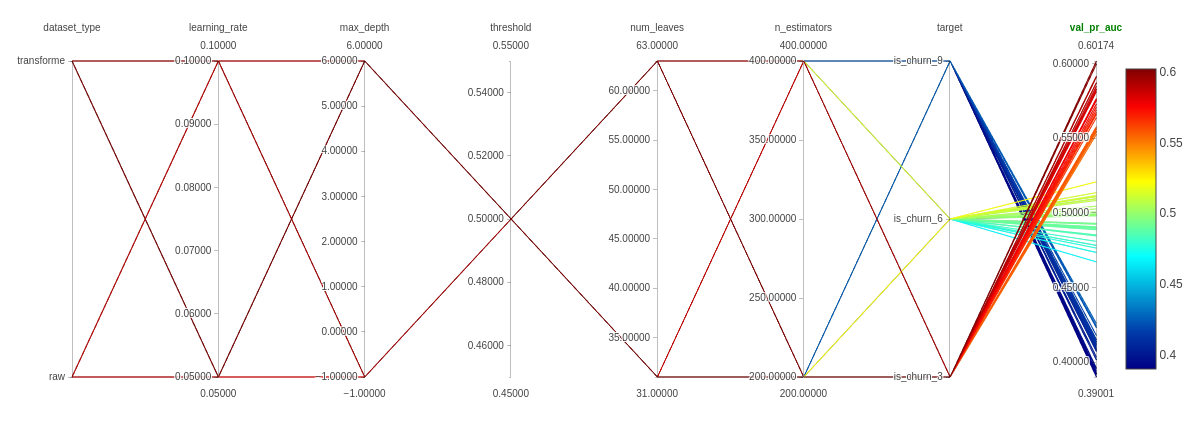
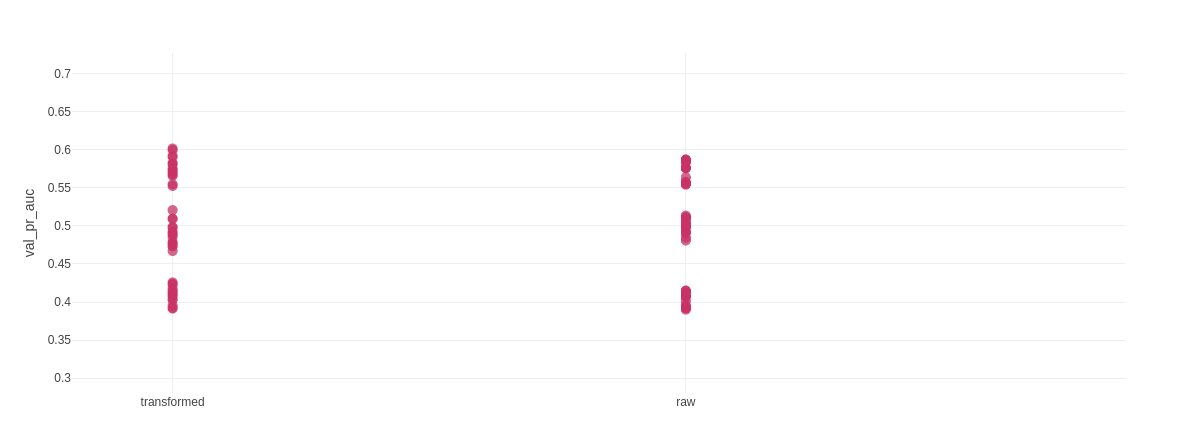

# Call Models

## Promote to Production

In [223]:
## 30 days - Transformed Features
promote_to_production('db4a6872b6e44d11898424ba774b7720')
## 60 days - Transformed Features
promote_to_production('cb743302afe8484ba431b702f2250315')
## 90 days - Raw Features
promote_to_production('b61920fcc3f34944aa30504d28594957')

## Remove Redundant Experiments

In [225]:
EXPERIMENT_ID = client.get_experiment_by_name("churn_prediction").experiment_id

KEEP_RUNS = {
    "db4a6872b6e44d11898424ba774b7720",
    "cb743302afe8484ba431b702f2250315",
    "b61920fcc3f34944aa30504d28594957",
    "models"
}

exp_dir = MLRUNS_DIR / EXPERIMENT_ID

for run_dir in exp_dir.iterdir():
    if not run_dir.is_dir():
        continue
    if run_dir.name in KEEP_RUNS:
        continue

    print(f"Deleting run: {run_dir.name}")
    shutil.rmtree(run_dir)

Deleting run: 8475ae8de14f49a68778821c6d740515
Deleting run: be46f1ba92d1489099033315e55021c0
Deleting run: 9c3b002475db49e0bee33caf71f09ef4
Deleting run: f13a8a11afef405e9f5df2cf7cf33245
Deleting run: b6fa546e20e5408eb476eb3c227238a3
Deleting run: 50be7138fa964fa4b28d29cb3187a11b
Deleting run: 4090b6f047e441c9a584f95205b0e5d6
Deleting run: 36bdb3e2ebd44ae28d104a57cc51874e
Deleting run: 60dd55bdd3c84ae7963f480b459bcc6c
Deleting run: 4929f5c0f6e34fce914e81da59710831
Deleting run: 7e9eef32f8054491bbb18e93c00ca24f
Deleting run: 96828848431943e393fa9a0c35f8e5a3
Deleting run: dcbfb78a682e4b259b0a0326ba7e5262
Deleting run: f95ae4f46ee548d4af2d7ad1d20b16e2
Deleting run: 48118ad759bd4f19bdc1a750699a9961
Deleting run: b1cc0af5bc264651ab17c514a5c0e1fc
Deleting run: 5eec60d23bff49f49fca0637efbfca77
Deleting run: 194d2fbbde264068910dfb502d7a9d2c
Deleting run: f72e77094ae74ffda329248c4cd8ae92
Deleting run: 1e5ca82e732f4eb3b45d6791fc36bb21
Deleting run: 4fd7dd0b4794407bb0579e2599c78c07
Deleting run:

## Load Data and Models

In [215]:
raw_features_df = load_features(
    "raw",
    gold_dir=CLASSIFIER_DATA_PATH
)

In [216]:
transformed_features_by_target = load_features(
    "transformed",
    gold_dir=CLASSIFIER_DATA_PATH
)

In [233]:
models, metadata = load_churn_classifiers()

In [229]:
models

{('is_churn_90_days',
  'transformed'): LGBMClassifier(n_estimators=200, n_jobs=-1, num_leaves=63, objective='binary',
                random_state=42),
 ('is_churn_60_days',
  'transformed'): LGBMClassifier(learning_rate=0.05, max_depth=6, n_estimators=200, n_jobs=-1,
                objective='binary', random_state=42),
 ('is_churn_30_days',
  'transformed'): LGBMClassifier(learning_rate=0.05, max_depth=6, n_estimators=200, n_jobs=-1,
                objective='binary', random_state=42)}

In [ ]:
for target in models:
    print(target)


('is_churn_90_days', 'transformed')
('is_churn_60_days', 'transformed')
('is_churn_30_days', 'transformed')


## Inference

In [236]:
predict_churn(
    customer_id="C01552",
    horizon_days=30,
    raw_features_df=raw_features_df,
    transformed_features_by_target=transformed_features_by_target,
    models=models,
    metadata=metadata
)

{'churn_probability': 0.3401, 'churn_label': 'low_risk'}

In [180]:
predict_churn(
    customer_id="C01553",
    horizon_days=30,
    raw_features_df=raw_features_df,
    transformed_features_by_target=transformed_features_by_target,
    models=models,
    metadata=metadata
)

{'churn_probability': 0.9268, 'churn_label': 'high_risk'}

## Log Inference Results

Purpose: to compare to other models later.

In [238]:
customer_ids=list(transactions_modeling_df['customer_id'].unique())

In [240]:
# 30 / 60 / 90 day predictions
p30 = (
    predict_churns(
        customer_ids=customer_ids,
        horizon_days=30,
        raw_features_df=raw_features_df,
        transformed_features_by_target=transformed_features_by_target,
        models=models,
        metadata=metadata,
    )["churn_probability"]
    .rename("p_is_churn_30_days")
)

p60 = (
    predict_churns(
        customer_ids=customer_ids,
        horizon_days=60,
        raw_features_df=raw_features_df,
        transformed_features_by_target=transformed_features_by_target,
        models=models,
        metadata=metadata,
    )["churn_probability"]
    .rename("p_is_churn_60_days")
)

p90 = (
    predict_churns(
        customer_ids=customer_ids,
        horizon_days=90,
        raw_features_df=raw_features_df,
        transformed_features_by_target=transformed_features_by_target,
        models=models,
        metadata=metadata,
    )["churn_probability"]
    .rename("p_is_churn_90_days")
)

In [241]:
# Combine (index-safe)
prediction_df = pd.concat([p30, p60, p90], axis=1)

In [243]:
output_path = (
    BASE_GOLD_DIR / "cut_120d"
    / "inference"
    / "churn_classifier_targets.csv"
)

prediction_df.to_csv(output_path)